# DATATHLON 2023 - BTK (Troia's Notebook)

Contributors: 

Semih Sarı (4th-year undergraduate student in Computer Engineering at ÇOMÜ)

Dr. Ulya Bayram (Assistant Professor @ Department of Electrical and Electronics Engineering, ÇOMÜ).

We chose the name "Troia" for our group in this competition because we are representing Çanakkale Onsekiz Mart University.

![TROIA](https://www.getsupport.co.uk/wp-content/uploads/2020/12/trojan-horse.jpg)

Photo reference: https://www.getsupport.co.uk/wp-content/uploads/2020/12/trojan-horse.jpg

### Required Libraries

In [2]:
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

!pip install catboost
!pip install lightgbm
!pip install xgboost

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

SEED = 17 # License plate number of Çanakkale :)

DIR_ = "/work/" # Here we set the directory of the files as a global variable.
# In addition to Kaggle, we also used Deepnote.com to write common code. 
#So this dir_ will change depending on what environment you are using

TARGET = "Öbek İsmi" # Our target (i.e., labels) is in this column

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 KB 12.2 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 9.4 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
def prepare_df(df):

    """
        The "index" column is being removed by default.
        It will be needed for both training and testing.
    """
    
    df.drop(columns=["index"], axis=1, inplace = True)

    return df
 

## 1) VISUAL DATA ANALYSIS and INTERPRETATION STUDY

### 1.1) Helper Functions Class

In [ ]:
class DataframeAnalyzer:

    def __init__(self, dataframe):

        self.df = dataframe

        # also separate the categorical & numerical columns, will be necessary later
        self.categorical_cols, self.numerical_cols = self.get_column_names()

    def get_column_names(self):
        """
            We are categorizing the columns as categorical and numerical.

            Output: List of names of categorical columns, list of names of numerical columns.
        """
        categorical_cols = [col for col in self.df.columns if self.df[col].dtypes == "O"]
        categorical_cols.remove(TARGET)

        numerical_cols = [col for col in self.df.columns if self.df[col].dtypes != "O"]

        print(f'Number of categorical_cols: {len(categorical_cols)}')
        print(f'Number of numerical_cols: {len(numerical_cols)}')

        return categorical_cols, numerical_cols
    
    def get_categorical_cols(self):
        """
            The goal is to provide these categorical columns when requested.
        """
        return self.categorical_cols

    def get_numerical_cols(self):
        """
            The goal is to provide these numerical columns when requested.
        """
        return self.numerical_cols

    def print_df(self):
        """
            The function's task is to print standard information.
        """
        
        print("Dataframe Shape:\n--------------")
        print(self.df.shape)
        
        print("\nValue Types:\n-------------")
        print(self.df.dtypes)
        
        print("\nNumber of null's per column:\n--------------------")
        print(self.df.isnull().sum())
        
        print("\nDescriptive Statistics:\n--------------")
        desc_stats = self.df.describe()
        print(desc_stats.T)
        
    def summarize_cat_columns(self):
        print("\nCategorical Column Summaries:\n---------------")

        # Create a sorted list of target names
        sorted_target_names = sorted(training_df[TARGET].unique())

        for cat_col in self.categorical_cols:
            print(f"\n----- {cat_col} -----")
            print(self.df[cat_col].value_counts())
            print("Ratio:\n------\n", self.df[cat_col].value_counts() / len(self.df))

            plt.figure(figsize=(12, 8))
            happy_colors = ['#FFC300', '#AFEEEE', '#FF0000', '#191970', '#FF1493', '#4CAF50', '#3498DB', '#9B59B6']
            sns.set_palette(happy_colors)
            ax = sns.countplot(x=cat_col, data=training_df, hue=TARGET, 
                                hue_order=sorted_target_names, linewidth=1.5, edgecolor="black")
            # Set vertical gridlines
            ax.grid(axis='y', linestyle='--', alpha=0.7)
            plt.title(f"{cat_col} Distribution", fontsize=16)
            plt.xlabel(cat_col, fontsize=15)
            plt.ylabel("Number of people", fontsize=15)
            plt.xticks(rotation=45)
            # Change x and y-axis tick label font size
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15)

            sns.despine()
            plt.tight_layout()

            # Move legend outside the plot
            plt.legend(title=TARGET, title_fontsize=18, fontsize=15, bbox_to_anchor=(1.05, 1), loc='upper left')

            plt.show()

    def summarize_num_columns(self):   
        print("\nNumerical Column Summaries:\n----------------")

        # Create a sorted list of target names
        sorted_target_names = sorted(training_df[TARGET].unique())

        for num_col in self.numerical_cols:
            print(f"\n----- {num_col} -----")
            print("Min:", self.df[num_col].min())
            print("Mean:", self.df[num_col].mean())
            print("Median:", self.df[num_col].median())
            print("Max:", self.df[num_col].max())
            print("Std Dev:", self.df[num_col].std())

            # Set style and palette
            sns.set(style="whitegrid")
            happy_colors = ['#FFC300', '#AFEEEE', '#FF0000', '#ADFF2F', '#FF1493', '#4CAF50', '#3498DB', '#9B59B6']
            sns.set_palette(happy_colors)

            # Create a violin plot
            plt.figure(figsize=(14, 8))
            ax = sns.violinplot(x=TARGET, y=num_col, data=self.df, inner="quartile", 
                                linewidth=2, order=sorted_target_names)
            ax.grid(axis='y', linestyle='--', alpha=0.7)

            # Set title and labels
            plt.title(f'Distribution of {num_col}', fontsize=16)
            plt.xlabel(TARGET, fontsize=15)
            plt.ylabel(num_col, fontsize=15)

            # Change x and y-axis tick label font size
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15)

            # Rotate x-axis labels for better readability
            plt.xticks(rotation=45, ha='right')

            # Adjust plot layout
            sns.despine(trim=True)
            plt.tight_layout()

            # Show the plot
            plt.show()


    def show_correlation_matrix(self):
        print("\nCorrelation Matrix:\n-----------------")
        corr_matrix = self.df.corr()
        
        # Create a heatmap using seaborn
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
        plt.title("Correlation Matrix Heatmap of Training")
        plt.show()
    
    def get_target_summary(self):
        """
            -It generates a summary report that shows the relationship 
             between the target variable and different categorical and numerical features: 
            -It presents the mean values of the target variable
             grouped by various categorical and numerical columns (i.e., features).

        """
        print("\n---------- Numerical Columns vs Target (Öbek İsmi) ----------\n")
        print(self.df.groupby(TARGET).agg({self.numerical_cols: "mean"}), end="\n")
        print("\n---------- Categorical Columns vs Target (Öbek İsmi) ----------\n")
        print(pd.DataFrame({"TARGET_MEAN": self.df.groupby(self.categorical_cols)[TARGET].mean()}), end="\n")



### 1.2) Statistical and Visual Analysis of Training Data

In [ ]:
# Starting to read and analyze the training set of the dataset.
training_df = pd.read_csv(DIR_ + "train.csv")
training_df = prepare_df(training_df)

print(training_df.head())
print("\n")

analyzer = DataframeAnalyzer(training_df)

  Cinsiyet Yaş Grubu Medeni Durum         Eğitim Düzeyi                 İstihdam Durumu  Yıllık Ortalama Gelir Yaşadığı Şehir     En Çok İlgilendiği Ürün Grubu  Yıllık Ortalama Satın Alım Miktarı  Yıllık Ortalama Sipariş Verilen Ürün Adedi Eğitime Devam Etme Durumu Öbek İsmi  Yıllık Ortalama Sepete Atılan Ürün Adedi
0    Kadın     31-40        Bekar  Yüksek Lisans Mezunu  Düzenli ve Ücretli Bir İşi Var          748266.440879    Büyük Şehir  Elektronik ve Teknolojik Ürünler                        32010.900881                                   37.310644                   Etmiyor    obek_4                                102.936904
1    Erkek       >60         Evli           Lise Mezunu             Kendi İşinin Sahibi          246298.609605    Küçük Şehir                  Spor Malzemeleri                         4145.729891                                   11.554851                   Etmiyor    obek_5                                 82.176053
2    Erkek     18-30        Bekar           Li

In [ ]:
analyzer.print_df()

Dataframe Shape:
--------------
(5460, 13)

Value Types:
-------------
Cinsiyet                                       object
Yaş Grubu                                      object
Medeni Durum                                   object
Eğitim Düzeyi                                  object
İstihdam Durumu                                object
Yıllık Ortalama Gelir                         float64
Yaşadığı Şehir                                 object
En Çok İlgilendiği Ürün Grubu                  object
Yıllık Ortalama Satın Alım Miktarı            float64
Yıllık Ortalama Sipariş Verilen Ürün Adedi    float64
Eğitime Devam Etme Durumu                      object
Öbek İsmi                                      object
Yıllık Ortalama Sepete Atılan Ürün Adedi      float64
dtype: object

Number of null's per column:
--------------------
Cinsiyet                                      0
Yaş Grubu                                     0
Medeni Durum                                  0
Eğitim Düzeyi     

In [ ]:
# Obtaining categorical and numerical variables
categorical_cols = analyzer.get_categorical_cols()
numerical_cols = analyzer.get_numerical_cols()

### 1.2.1) Analysis of categorical columns

In [ ]:
categorical_cols

['Cinsiyet',
 'Yaş Grubu',
 'Medeni Durum',
 'Eğitim Düzeyi',
 'İstihdam Durumu',
 'Yaşadığı Şehir',
 'En Çok İlgilendiği Ürün Grubu',
 'Eğitime Devam Etme Durumu']


Categorical Column Summaries:
---------------

----- Cinsiyet -----
Erkek    2964
Kadın    2496
Name: Cinsiyet, dtype: int64
Ratio:
------
 Erkek    0.542857
Kadın    0.457143
Name: Cinsiyet, dtype: float64


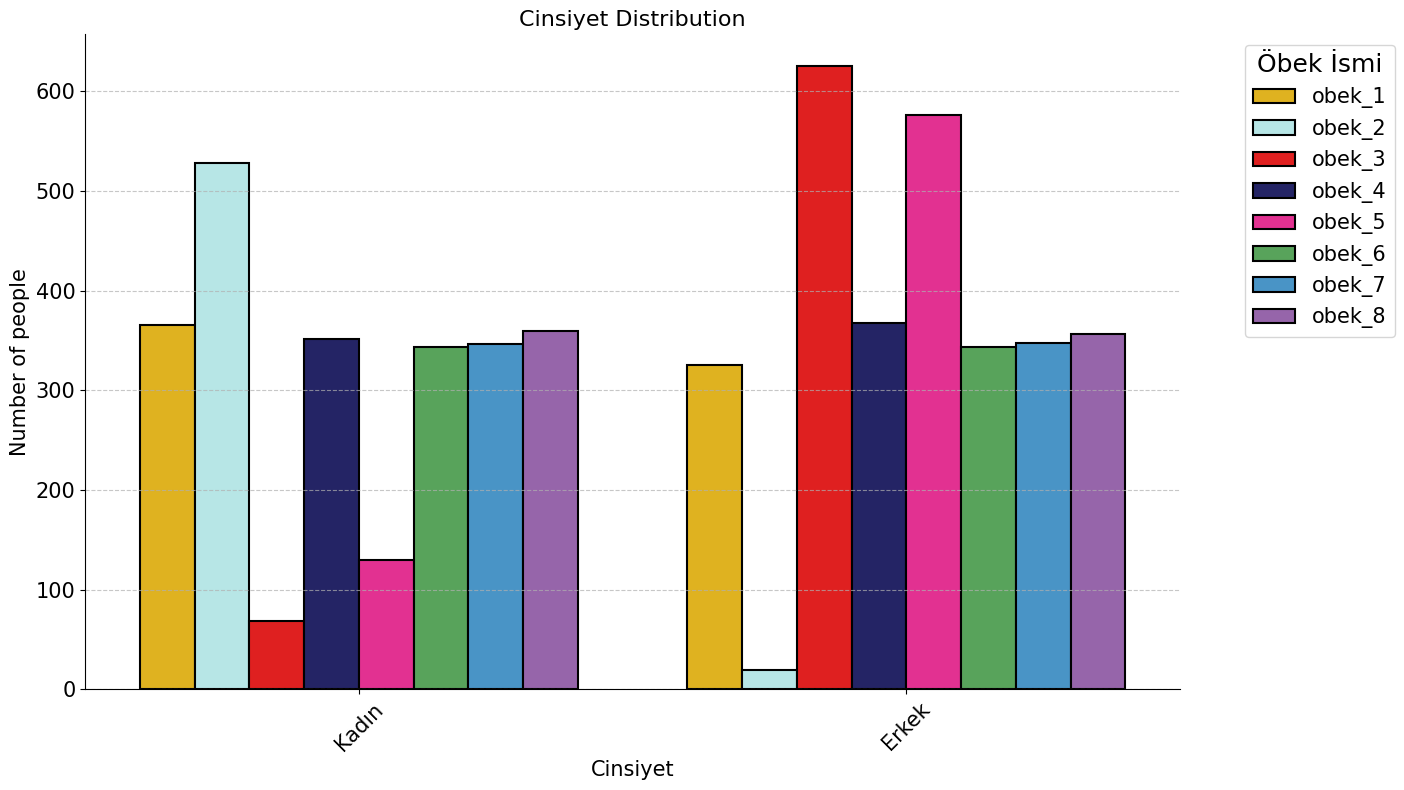


----- Yaş Grubu -----
18-30    1841
31-40    1477
51-60     861
41-50     727
>60       554
Name: Yaş Grubu, dtype: int64
Ratio:
------
 18-30    0.337179
31-40    0.270513
51-60    0.157692
41-50    0.133150
>60      0.101465
Name: Yaş Grubu, dtype: float64


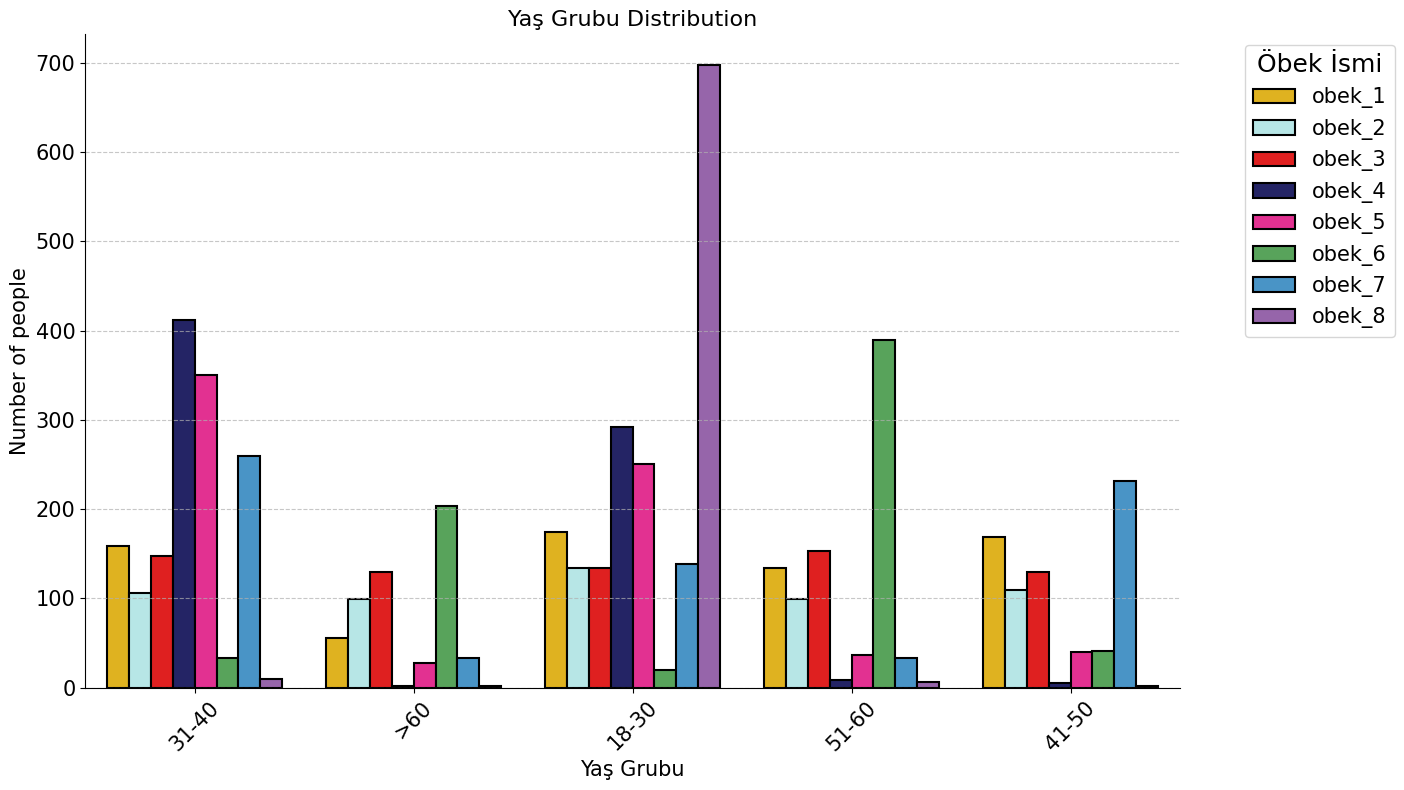


----- Medeni Durum -----
Evli     2834
Bekar    2626
Name: Medeni Durum, dtype: int64
Ratio:
------
 Evli     0.519048
Bekar    0.480952
Name: Medeni Durum, dtype: float64


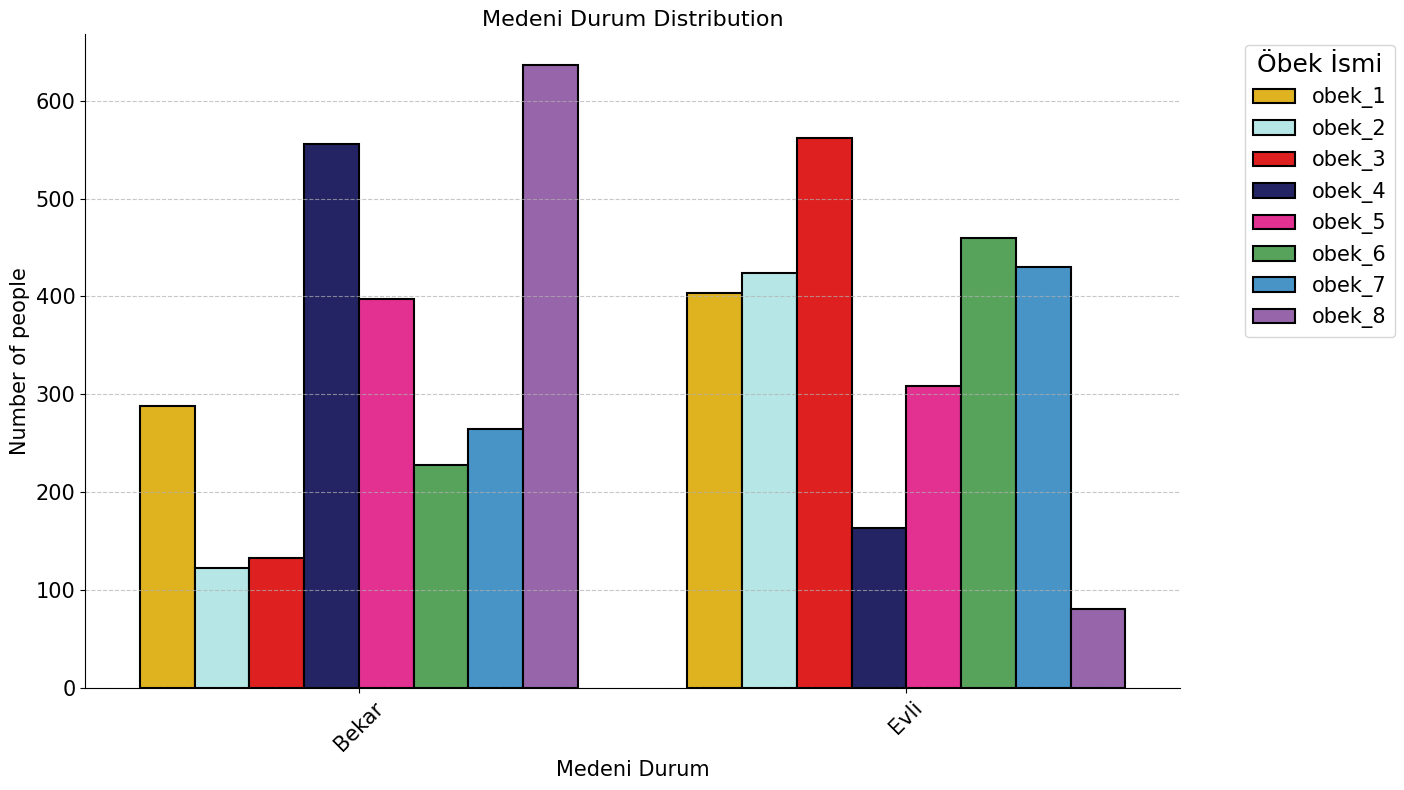


----- Eğitim Düzeyi -----
Lise Mezunu             1388
Üniversite Mezunu       1257
Yüksekokul Mezunu        588
Yüksek Lisans Mezunu     545
İlkokul Mezunu           417
Ortaokul Mezunu          412
Eğitimsiz                381
Doktora Mezunu           263
Doktora Ötesi            209
Name: Eğitim Düzeyi, dtype: int64
Ratio:
------
 Lise Mezunu             0.254212
Üniversite Mezunu       0.230220
Yüksekokul Mezunu       0.107692
Yüksek Lisans Mezunu    0.099817
İlkokul Mezunu          0.076374
Ortaokul Mezunu         0.075458
Eğitimsiz               0.069780
Doktora Mezunu          0.048168
Doktora Ötesi           0.038278
Name: Eğitim Düzeyi, dtype: float64


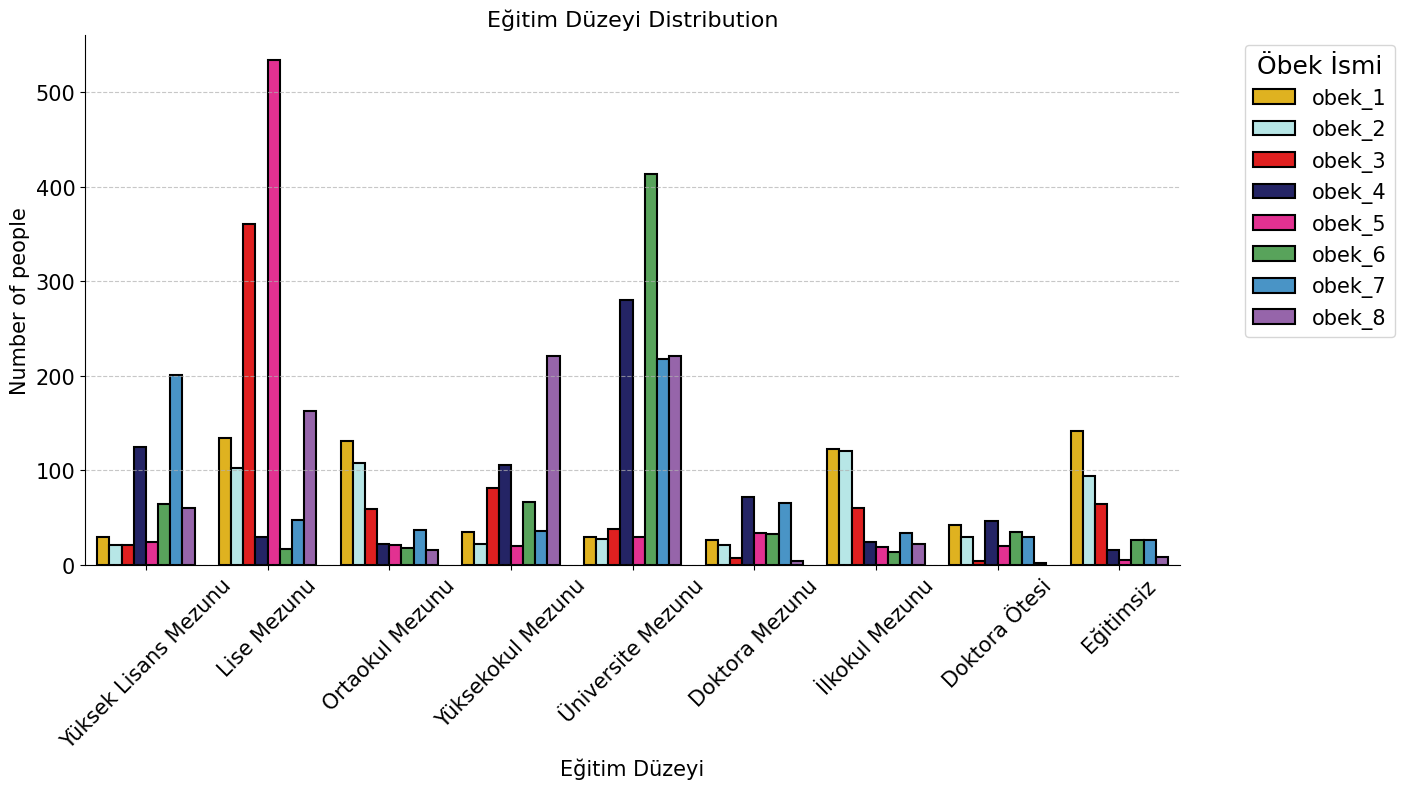


----- İstihdam Durumu -----
Düzenli ve Ücretli Bir İşi Var    2768
İşsiz veya Düzenli Bir İşi Yok    1349
Kendi İşinin Sahibi                879
Emekli                             464
Name: İstihdam Durumu, dtype: int64
Ratio:
------
 Düzenli ve Ücretli Bir İşi Var    0.506960
İşsiz veya Düzenli Bir İşi Yok    0.247070
Kendi İşinin Sahibi               0.160989
Emekli                            0.084982
Name: İstihdam Durumu, dtype: float64


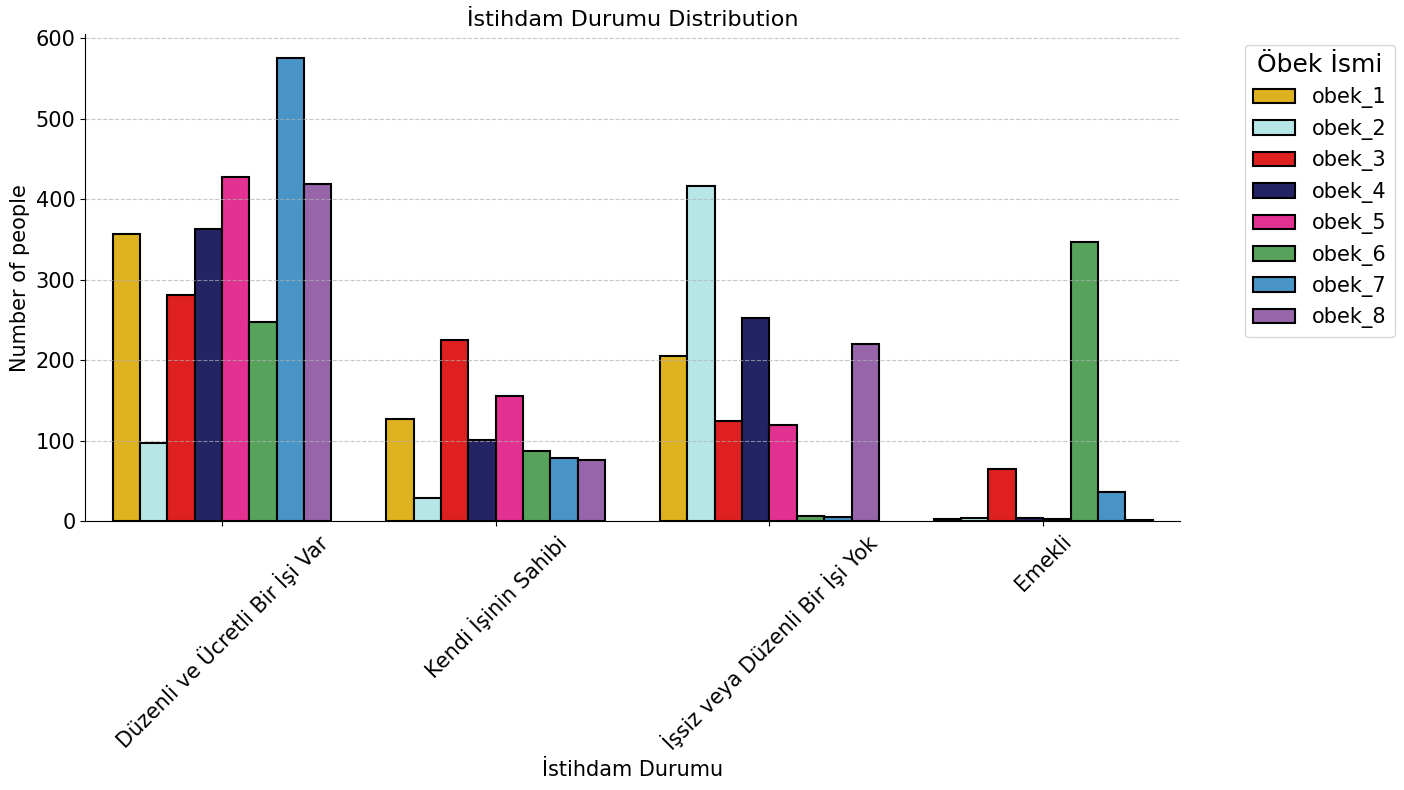


----- Yaşadığı Şehir -----
Büyük Şehir        1959
Küçük Şehir        1842
Köy veya Kasaba    1092
Kırsal              567
Name: Yaşadığı Şehir, dtype: int64
Ratio:
------
 Büyük Şehir        0.358791
Küçük Şehir        0.337363
Köy veya Kasaba    0.200000
Kırsal             0.103846
Name: Yaşadığı Şehir, dtype: float64


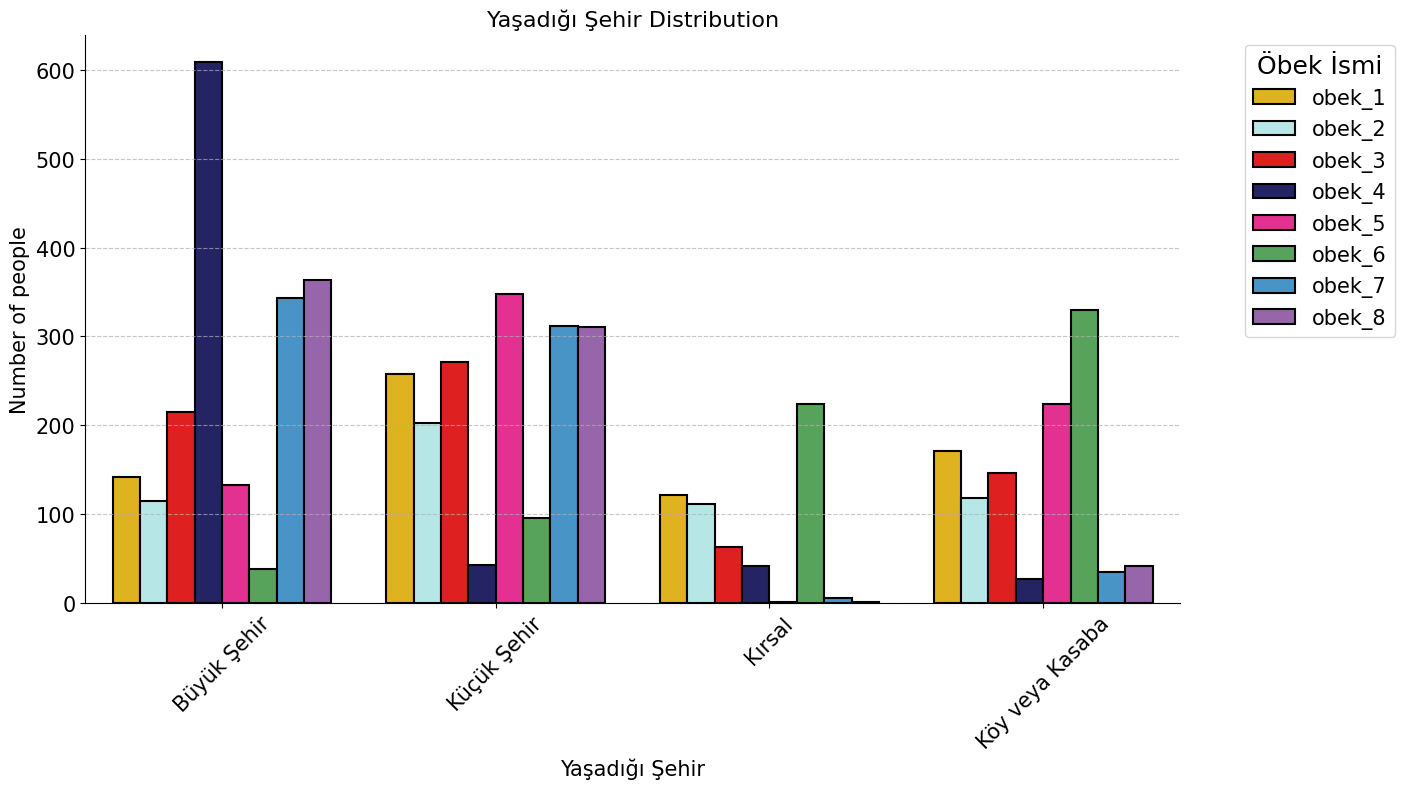


----- En Çok İlgilendiği Ürün Grubu -----
Giyim                               1487
Ev ve Mobilya                       1114
Elektronik ve Teknolojik Ürünler    1029
Spor Malzemeleri                    1001
Kozmetik                             829
Name: En Çok İlgilendiği Ürün Grubu, dtype: int64
Ratio:
------
 Giyim                               0.272344
Ev ve Mobilya                       0.204029
Elektronik ve Teknolojik Ürünler    0.188462
Spor Malzemeleri                    0.183333
Kozmetik                            0.151832
Name: En Çok İlgilendiği Ürün Grubu, dtype: float64


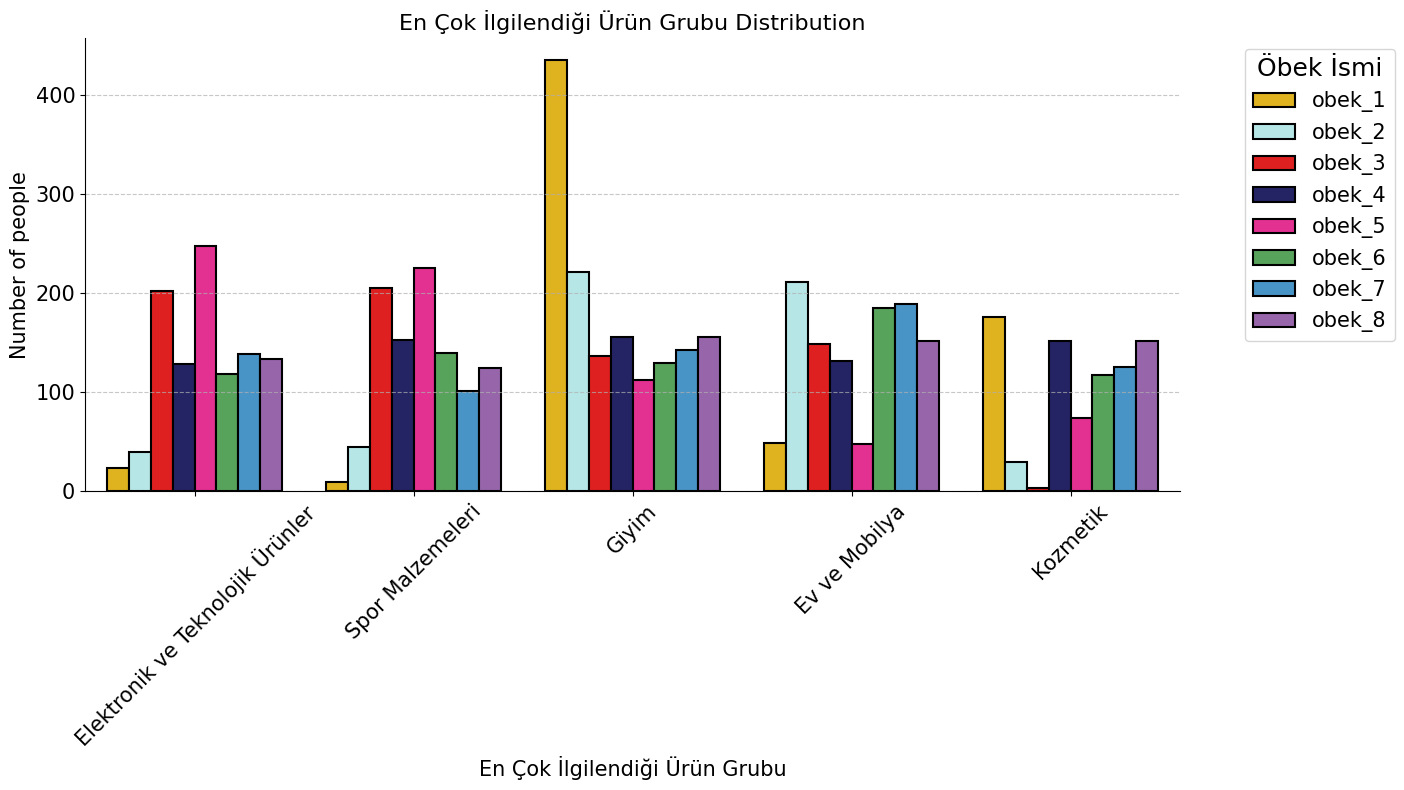


----- Eğitime Devam Etme Durumu -----
Etmiyor    4554
Ediyor      906
Name: Eğitime Devam Etme Durumu, dtype: int64
Ratio:
------
 Etmiyor    0.834066
Ediyor     0.165934
Name: Eğitime Devam Etme Durumu, dtype: float64


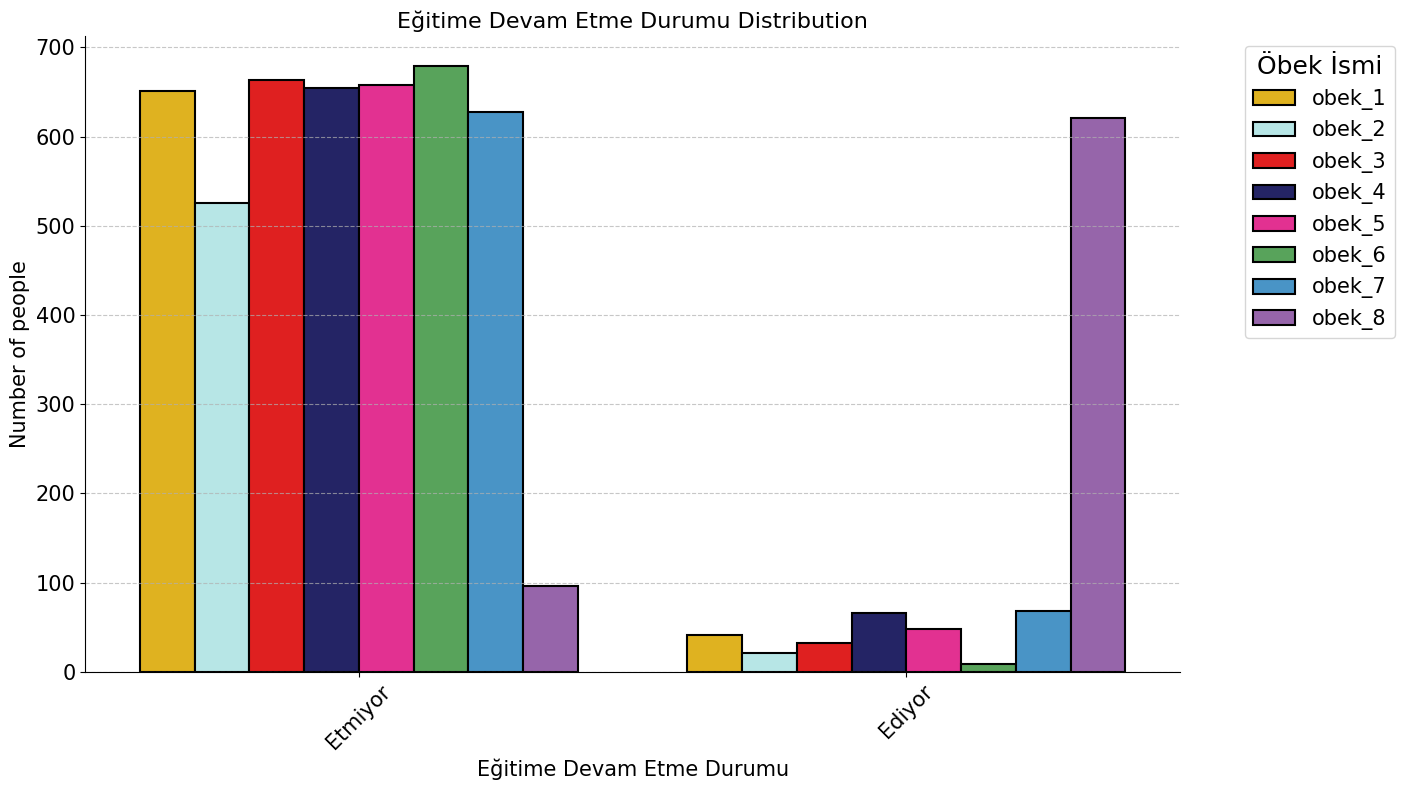

In [ ]:
analyzer.summarize_cat_columns()

We have made the following observations based on categorical plots and the number of individuals in each cluster:

- Öbek 1: Mostly engaged in clothing and cosmetics shopping, low education level, mostly young below 60.

- Öbek 2: Comprised mainly of married women, engaged in clothing and furniture shopping, with a maximum education level of high school, mostly unemployed, and mostly young below 60.

- Öbek 3: Includes married men of all ages, except for cosmetics, they buy everything, most of them have a high school education, and they don't live in rural areas.

- Öbek 4: Single individuals, aged 18-40, living in major cities, at least college graduates, and highly educated, they buy everything.

- Öbek 5: Mostly males aged 18-40, high school graduates, not living in rural areas, and not retired.

- Öbek 6: Preferring rural areas, villages, and small towns, mostly retired individuals aged 51 and above, university graduates.

- Öbek 7: Living in small and large cities, at least college graduates, with regular jobs, aged 18-50.

- Öbek 8: The young population continuing their education.

### 1.2.2) Analysis of numerical columns

In [ ]:
numerical_cols

['Yıllık Ortalama Gelir',
 'Yıllık Ortalama Satın Alım Miktarı',
 'Yıllık Ortalama Sipariş Verilen Ürün Adedi',
 'Yıllık Ortalama Sepete Atılan Ürün Adedi']


Numerical Column Summaries:
----------------

----- Yıllık Ortalama Gelir -----
Min: 43922.98869298681
Mean: 363571.1334275545
Median: 286925.4360734618
Max: 1192437.1452577456
Std Dev: 219714.4424073492


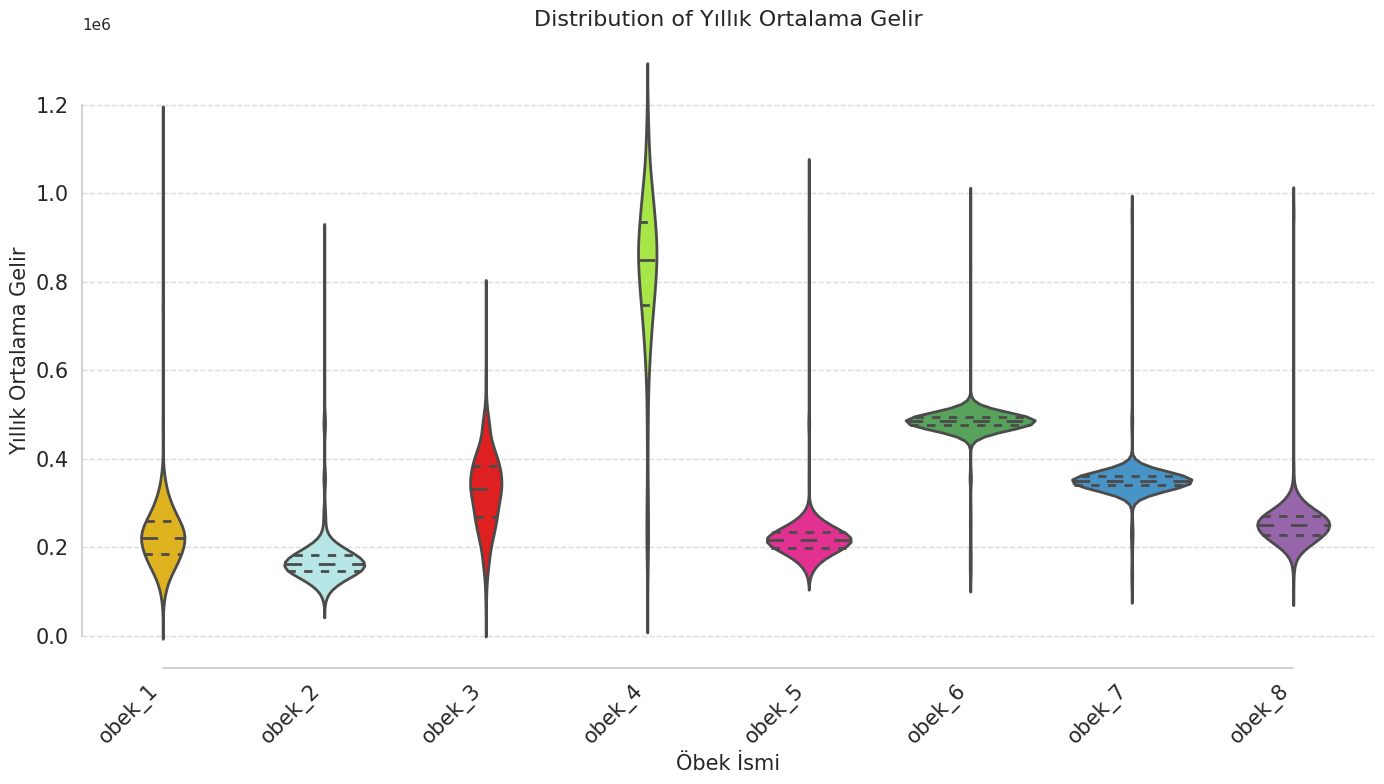


----- Yıllık Ortalama Satın Alım Miktarı -----
Min: 2859.2540004923017
Mean: 16616.612217082475
Median: 8426.818967242809
Max: 48605.59441519324
Std Dev: 14099.171703975773


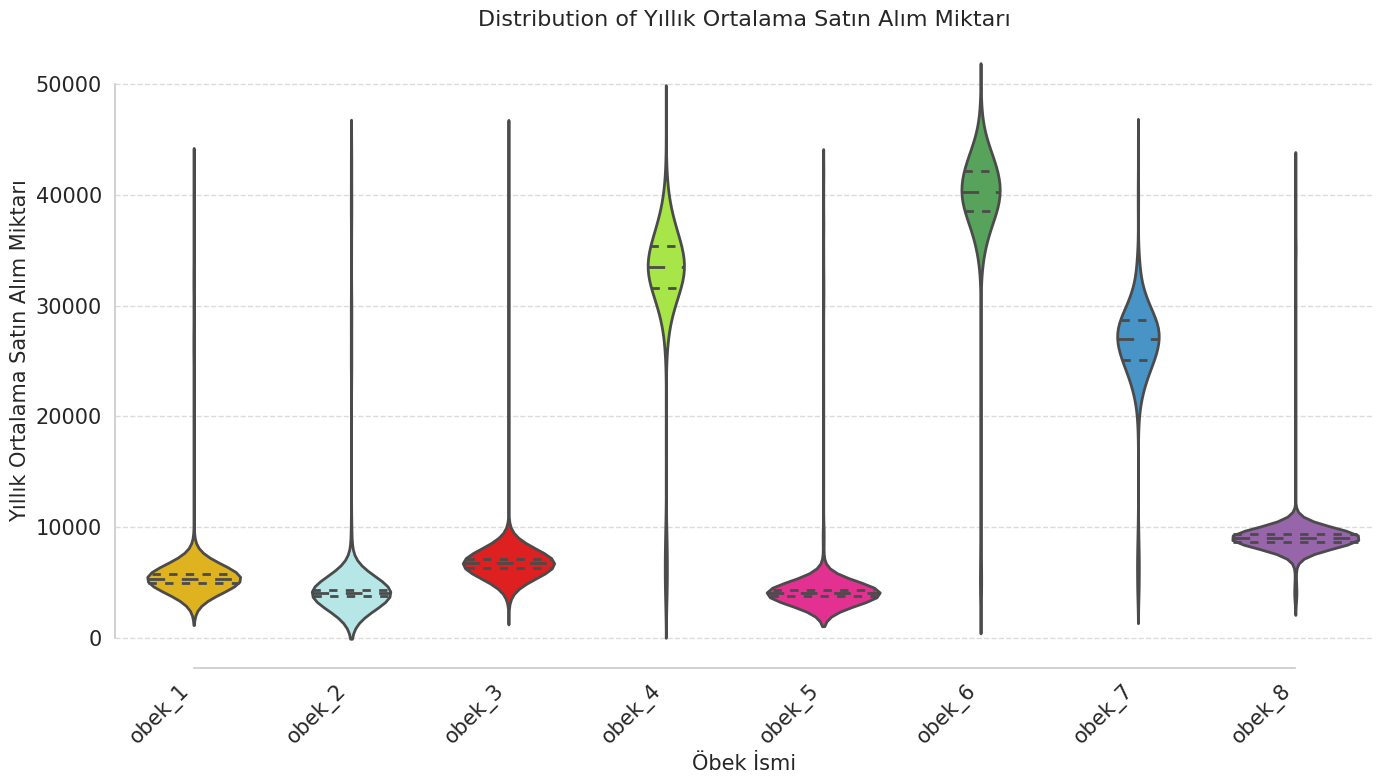


----- Yıllık Ortalama Sipariş Verilen Ürün Adedi -----
Min: 0.0
Mean: 24.04088445401229
Median: 20.095923614147452
Max: 64.61619598652867
Std Dev: 14.945655181963215


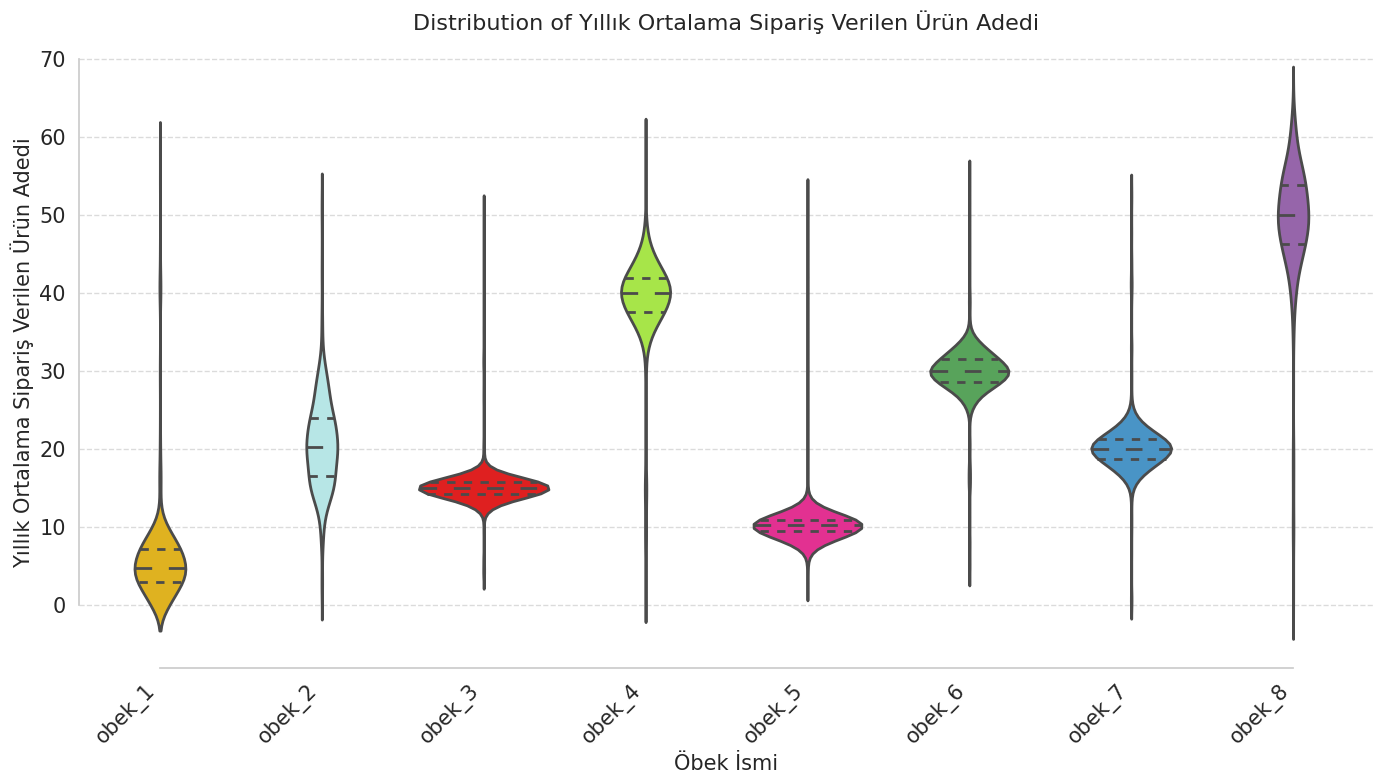


----- Yıllık Ortalama Sepete Atılan Ürün Adedi -----
Min: 3.977558775834797
Mean: 73.44569302866336
Median: 82.48557941901836
Max: 242.30844066611877
Std Dev: 47.2141837101441


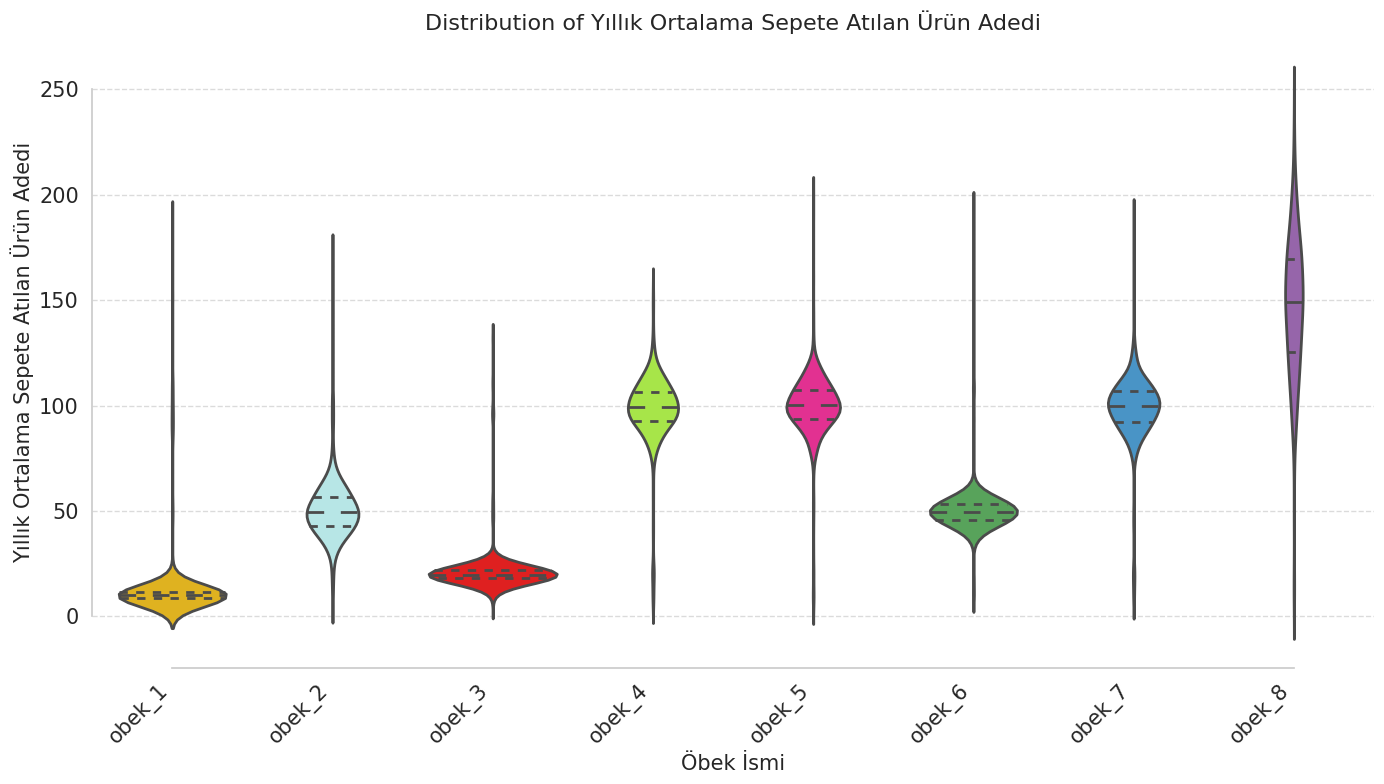

In [ ]:
analyzer.summarize_num_columns()

In addition to the information obtained from categorical columns, let's add the information from the violin plots of numerical columns:

- Öbek 1 (mostly engaged in clothing and cosmetics shopping, low education level, mostly young below 60) is the group with the least products added to the basket and the least products purchased.

- Öbek 2 (comprised mainly of married women, engaged in clothing and furniture shopping, with a maximum education level of high school, mostly unemployed, and mostly young below 60) has both low income and low spending habits.

- Öbek 3 (includes married men of all ages, except for cosmetics, they buy everything, most of them have a high school education, and they don't live in rural areas) adds fewer products to the basket.

- Öbek 4 (single individuals, aged 18-40, living in major cities, at least college graduates, and highly educated, they buy everything) has the highest average income annually. Additionally, they purchase a lot of products despite not adding many items to the basket. They must be buying expensive items.

- Öbek 5 (mostly males aged 18-40, high school graduates, not living in rural areas, and not retired) adds a lot to the basket but does not make purchases, and their income is low.

- Öbek 6 (preferring rural areas, villages, and small towns, mostly retired individuals aged 51 and above, university graduates) is the group that spends the most money.

- Öbek 7 (living in small and large cities, at least college graduates, with regular jobs, aged 18-50) is the third highest spending group.

- Öbek 8 (the young population continuing their education) is the group that, on average, adds the most products to the basket and makes the most purchases.

# 2) Data Preprocessing and Feature Engineering

All of these operations have been made functional. Data preparation process has been automated.

In [ ]:
## Helper Functions Class for Preprocessing

class CheckForOutliers:

    def __init__(self, dataframe):

        self.df = dataframe
    
    def check_outlier(self, col_name):
        """
        It checks if there are any outliers in the DataFrame based on the specified col_name column. 
        If there are outliers, it returns True; otherwise, it returns False.
        The determination is based on the threshold values specified in outlier_thresholds.
        """
        low_limit, up_limit = self.outlier_thresholds(col_name)
        if self.df[(self.df[col_name] > up_limit) | (self.df[col_name] < low_limit)].any(axis=None):
            return True
        else:
            return False

    def outlier_thresholds(self, col_name, q1=0.05, q3=0.95):
        """
        The outlier thresholds are defined here to determine outliers.
        """
        quartile1 = self.df[col_name].quantile(q1)
        quartile3 = self.df[col_name].quantile(q3)
        interquantile_range = quartile3 - quartile1
        up_limit = quartile3 + 1.5 * interquantile_range
        low_limit = quartile1 - 1.5 * interquantile_range

        return low_limit, up_limit


### 

## 2.1) Outlier Analysis

In [ ]:
prep = CheckForOutliers(training_df)

for col in numerical_cols:
    print(col, prep.check_outlier(col))


Yıllık Ortalama Gelir False
Yıllık Ortalama Satın Alım Miktarı False
Yıllık Ortalama Sipariş Verilen Ürün Adedi False
Yıllık Ortalama Sepete Atılan Ürün Adedi False


Since we will be using tree-based methods, higher threshold values have been set. No outliers were found in the numerical features. During model training, no data was discarded in the end.

## 2.2) Multivariate Outlier Analysis (LOF - Local Outlier Factor)

[-1.02942965 -0.97988463 -1.05155966 -1.05632515 -0.97669373]


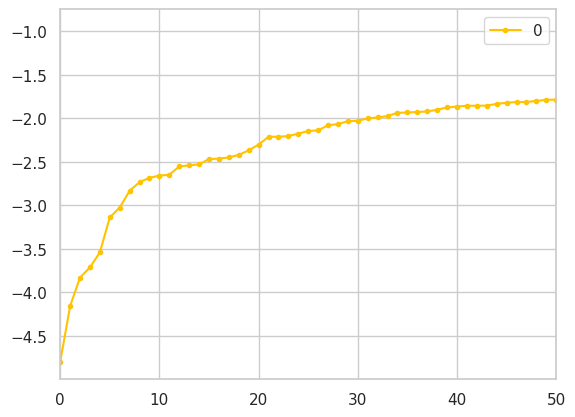

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=20)
clf.fit_predict(training_df[numerical_cols])
df_scores = clf.negative_outlier_factor_
print(df_scores[0:5])

scores = pd.DataFrame(np.sort(df_scores))
scores.plot(stacked = True,xlim=[0,50],style='.-')
plt.show()

In [ ]:
th = np.sort(df_scores)[5]
training_df[numerical_cols][df_scores<th]

,Yıllık Ortalama Gelir,Yıllık Ortalama Satın Alım Miktarı,Yıllık Ortalama Sipariş Verilen Ürün Adedi,Yıllık Ortalama Sepete Atılan Ürün Adedi
4204,422025.715497,27418.899652,37.222139,93.811982
4395,302240.117260,26581.049181,17.599960,105.747485
4999,43922.988693,4169.949102,2.934947,10.408325
5100,45695.091498,6740.639692,15.557786,16.284374
5130,299549.793156,27327.309076,19.524385,103.867181


We have decided not to use the results of the outlier detection part to avoid losing data.

## 2.3) Feature Engineering efforts yielded positive results for some and negative effects for others. These were identified during model training and performance evaluation.

We tried adding a large number of new features to existing columns. Our efforts are listed below. Some of them yielded successful results in certain models, while others did so in different models.

In [ ]:
numerical_cols

['Yıllık Ortalama Gelir',
 'Yıllık Ortalama Satın Alım Miktarı',
 'Yıllık Ortalama Sipariş Verilen Ürün Adedi',
 'Yıllık Ortalama Sepete Atılan Ürün Adedi']

In [ ]:
print(f"25th percentile value for Annual Average Income: {training_df['Yıllık Ortalama Gelir'].quantile(0.25)}\n"
      f"75th percentile value for Annual Average Income: {training_df['Yıllık Ortalama Gelir'].quantile(0.75)}")


25th percentile value for Annual Average Income: 215693.43930698355
75th percentile value for Annual Average Income: 468188.2217975914


%25 and %75 quartile values seem to be sufficient thresholds.

In [ ]:

def get_income_group(gelir):

    """
        We categorize people into 3 groups based on their annual average income.
        We found these threshold values through the quartile analysis process in the cell above.
        This new feature has positively influenced the validation performance of the model.
    """

    if gelir < 215693:
        return "Düşük Gelir"
    elif gelir >= 215693 and gelir < 468188:
        return "Orta Gelir"
    else:
        return "Yüksek Gelir"

def gender_age_merge(df):
    """
        Unlike the previous functions, it combines two categories to create new categories 
        and takes the entire dataframe as input to accomplish this.
        This new feature has had a positive impact on improving the model's validation performance.
    """

    # A new feature was created using gender and age group. (gender_age)
    df.loc[(df['Cinsiyet'] == 'Erkek') & (df['Yaş Grubu'] == '18-30'), 'gender_age'] = 'genc_erkek'
    df.loc[(df['Cinsiyet'] == 'Erkek') & (df['Yaş Grubu'].isin(['31-40', '41-50'])), 'gender_age'] = 'orta_erkek'
    df.loc[(df['Cinsiyet'] == 'Erkek') & (df['Yaş Grubu'].isin(['51-60', '>60'])), 'gender_age'] = 'yasli_erkek'

    df.loc[(df['Cinsiyet'] == 'Kadın') & (df['Yaş Grubu'] == '18-30'), 'gender_age'] = 'genc_kadin'
    df.loc[(df['Cinsiyet'] == 'Kadın') & (df['Yaş Grubu'].isin(['31-40', '41-50'])), 'gender_age'] = 'orta_kadin'
    df.loc[(df['Cinsiyet'] == 'Kadın') & (df['Yaş Grubu'].isin(['51-60', '>60'])), 'gender_age'] = 'yasli_kadin'

    return df


## 2.4) Encoding, Scaling

In [ ]:
# Functions for Data Preprocessing

def add_2_new_features(df):

    df["NEW_Income_Group"] = df["Yıllık Ortalama Gelir"].apply(get_income_group)
    df = gender_age_merge(df)

    return df

def prepare_files_w_extra_2_feats(DIR_, list_cat_cols, list_numerical_cols):
    """
    In our validation experiments, an ensemble model with 2 extra features achieved very successful results.
    Therefore, we wrote a separate function that includes these two extra features, reads and processes the data.
    This allows us to automate the operations and combine all our notebooks.

    inputs:
        DIR_               : directory where the files are located.
        list_cat_cols      : list of categorical column names.
        list_numerical_cols: list of numerical column names.
    """

    # Let's read the data from scratch because train_df will change in place with each experiment.
    # We want to read it again each time this function is called to be on the safe side.
    train = pd.read_csv(DIR_ + "train.csv")
    test = pd.read_csv(DIR_ + "test_x.csv")  # reading it for the first time

    train = prepare_df(train)
    test = prepare_df(test)  # remove the index

    # Target variable transformation (from strings to label numbers)
    y_labels_str = train[TARGET]
    conv_str2num_dict, conv_num2str_dict = class_str2num(y_labels_str)
    y_labels_num = [conv_str2num_dict[str_] for str_ in y_labels_str]

    y_labels_num = np.array(y_labels_num)  # 0,1...7
    train.drop(TARGET, axis=1, inplace=True)

    # Add two new features to both sets
    train = add_2_new_features(train)
    test = add_2_new_features(test)

    list_cat_cols.extend(["gender_age", "NEW_Income_Group"])

    # Apply One Hot Encoding to both sets
    train = pd.get_dummies(train, columns=list_cat_cols, drop_first=True)
    test = pd.get_dummies(test, columns=list_cat_cols, drop_first=True)

    # Standard normalization process for numerical variables
    scaler = StandardScaler()
    train[list_numerical_cols] = scaler.fit_transform(train[list_numerical_cols])
    test[list_numerical_cols] = scaler.transform(test[list_numerical_cols])

    # Total Cluster Count is our class count
    num_classes = len(set(y_labels_str))

    return train, y_labels_num, y_labels_str, test, num_classes, list_cat_cols


In [ ]:
# Data Preprocessing and Pre-Modeling Steps
def class_str2num(y_labels_str):
    """
    Function to be used in target variable transformation. In this function, we convert öbek_1 to 0 because some sklearn libraries
    prefer label values to start from 0. We keep the values as cluster numbers - 1.

    Input: List of string TARGET values like öbek_1, öbek_2, ...
    Output: Two dictionaries that convert these strings to numbers and vice versa.
    """
    list_unique = list(set(y_labels_str))
    conv_str2num_dict = {}
    conv_num2str_dict = {}
    
    for str_ in list_unique:
        conv_str2num_dict[str_] = int(str_.split("_")[1]) - 1
        conv_num2str_dict[int(str_.split("_")[1]) - 1] = str_
    
    return conv_str2num_dict, conv_num2str_dict

train, y_labels_num, y_labels_str, test, num_classes, categorical_cols = prepare_files_w_extra_2_feats(DIR_, categorical_cols, numerical_cols)

print(train.head(3))

conv_str2num_dict, conv_num2str_dict = class_str2num(y_labels_str)


   Yıllık Ortalama Gelir  Yıllık Ortalama Satın Alım Miktarı  Yıllık Ortalama Sipariş Verilen Ürün Adedi  Yıllık Ortalama Sepete Atılan Ürün Adedi  Cinsiyet_Kadın  Yaş Grubu_31-40  Yaş Grubu_41-50  Yaş Grubu_51-60  Yaş Grubu_>60  Medeni Durum_Evli  Eğitim Düzeyi_Doktora Ötesi  Eğitim Düzeyi_Eğitimsiz  Eğitim Düzeyi_Lise Mezunu  Eğitim Düzeyi_Ortaokul Mezunu  Eğitim Düzeyi_Yüksek Lisans Mezunu  Eğitim Düzeyi_Yüksekokul Mezunu  Eğitim Düzeyi_Üniversite Mezunu  Eğitim Düzeyi_İlkokul Mezunu  \
0               1.751048                            1.091958                                    0.887949                                  0.624683               1                1                0                0              0                  0                            0                        0                          0                              0                                   1                                0                                0                             0   
1         

# 3) Models

## 3.1) First Model

### Calling Selected Models

In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignore UserWarnings and ConvergenceWarnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# This function evaluates the performance of base models.
# It evaluates basic classification models on the given X data and y targets.
# Prints the results to the screen.
def base_models(X, y, scoring="accuracy"):
    print("Base Models....")
    
    # A list containing classification models to be evaluated along with their names
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ('LightGBM', LGBMClassifier())]

    for name, classifier in classifiers:
        # Evaluate classifiers with 5-fold cross-validation
        cv_results = cross_validate(classifier, X, y, cv=5, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

base_models(train, y_labels_num)


Base Models....
accuracy: 0.9474 (LR) 
accuracy: 0.9308 (KNN) 
accuracy: 0.9542 (SVC) 
accuracy: 0.8993 (CART) 
accuracy: 0.9548 (RF) 
accuracy: 0.9218 (Adaboost) 
accuracy: 0.9462 (GBM) 
accuracy: 0.9522 (XGBoost) 
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1084
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 36
[LightGBM] [Info] Start training from score -2.064896
[LightGBM] [Info] Start training from score -2.299842
[LightGBM] [Info] Start training from score -2.061292
[LightGBM] [Info] Start training from score -2.025953
[LightGBM] [Info] Start training from score -2.047006
[LightGBM] [Info] Start training from score -2.072142
[LightGBM] [Info] Start t

Base models, i.e., commonly used machine learning methods in the literature and competitions, with their default parameters, yield the following 5-fold cross-validation results from the training set:

accuracy: 0.9474 (LR) 
accuracy: 0.9308 (KNN) 
accuracy: 0.9542 (SVC) 
accuracy: 0.8993 (CART) 
accuracy: 0.9546 (RF) 
accuracy: 0.9218 (Adaboost) 
accuracy: 0.9467 (GBM) 
accuracy: 0.9522 (XGBoost) 
accuracy: 0.9538 (LightGBM) 

The highest cross-validation results were obtained from RF and LightGBM. We are definitely selecting these two.

As the third method (we need an odd number for voting), we have selected KNN. Its results are not higher than the remaining methods, but it has a different algorithmically. According to our hypothesis, if we ensemble this different algorithm model with the two successful methods, we can obtain a model capable of good generalization. This is because, even if we ensemble many tree-based models, it won't make much difference if we use just one RF since the algorithms will keep finding the same things.

CART and Adaboost were eliminated because they performed poorly. LR was too simple for this ensemble. Since we already have LightGBM, we didn't see the need to add GBM to the ensemble. Here, even though SVC performed well, it was eliminated from the ensemble for two reasons. First, fine-tuning SVC takes much longer compared to others (based on our previous project experiences), and second, we need an odd number of models. Instead of SVC, we chose KNN for its speed and significantly different algorithm. Given that this problem resembles a clustering problem, using KNN in the ensemble seemed more reasonable to us.

### Hyperparameter Optimization

As a final result, we selected the KNN-RF-LGBM Stacking Ensemble model that performed the best.


In [ ]:
# Bu fonksiyon, GridSearchCV kullanarak sınıflandırma modellerinin hiperparametrelerini optimize eder.
# Verilen X verileri ve y hedefleri üzerinde modelleri optimize eder.
# Optimizasyon sonuçlarını ekrana yazdırır.
# Optimizasyon sonrası en iyi modelleri döndürür.
def hyperparameter_optimization(X, y, cv=5, scoring="accuracy"):
    print("Hyperparameter Optimization....")
    
    best_models = {}
    
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        
        # Çapraz doğrulama ile sınıflandırıcıları değerlendirme (öncesinde)
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        # GridSearchCV ile en iyi parametreleri bulma ve son modeli oluşturma
        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        # Çapraz doğrulama ile sınıflandırıcıları değerlendirme (sonrasında)
        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        
        # En iyi modeli bir sözlüğe ekleyerek kaydetme
        best_models[name] = final_model
    
    return best_models



### Defining Sets of Parameters for Search

In [ ]:
knn_params = {"n_neighbors": range(1,50)}

rf_params = {    
    'max_depth': [None,10,20]
   }


lightgbm_params = {"learning_rate": [0.01,0.5],
                "n_estimators": [280,300,500],
                'objective': ['multiclass'],
                    'metric': ['multi_logloss'],  # For multiclass classification, 'multi_error' is used with 1 - accuracy
                    'num_class': [8],           # Number of classes in the dataset
                    'boosting_type': ['gbdt'],
                    'num_leaves': [31],
                    'verbose': [0]}


# Models to be Used in Parameter Optimization:
classifiers = [
            ('LightGBM', LGBMClassifier(), lightgbm_params),
            ('KNN', KNeighborsClassifier(), knn_params),
            ("RF", RandomForestClassifier(), rf_params)
            ]


In [ ]:
best_models = hyperparameter_optimization(train, y_labels_num)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [ ]:
best_models

{'LightGBM': LGBMClassifier(learning_rate=0.01, metric='multi_logloss', n_estimators=500,
                num_class=8, objective='multiclass', verbose=0),
 'KNN': KNeighborsClassifier(n_neighbors=42),
 'RF': RandomForestClassifier()}

These are the best parameters. We can continue with these.

### Stacking & Ensemble Learning

In [ ]:
# This function creates the Voting Classifier model.
# It creates and evaluates the Voting Classifier using the best models and data provided.
# Prints the results to the screen.
def voting_classifier(best_models, X, y):
     print("Voting Classifier...")
     
     # Create the Voting Classifier using the best models specified
     voting_clf = VotingClassifier(estimators=[('KNN', best_models["KNN"]), ('RF', best_models["RF"]),
                                               ('LightGBM', best_models["LightGBM"])],
                                   voting='soft').fit(X, y)
     
     # Evaluate the Voting Classifier's performance with cross-validation
     cv_results = cross_validate(voting_clf, X, y, cv=5, scoring=["accuracy"])

     print(cv_results)
     print("5-fold cross-validation results:")
     print(f"\n\nMean Accuracy: {cv_results['test_accuracy'].mean()}")
     print(f"STD Accuracy: {cv_results['test_accuracy'].std()}")
     #print(f"F1Score: {cv_results['test_f1'].mean()}")
     
     return voting_clf


In [ ]:
# Creating and Saving the Model
voting_clf = voting_classifier(best_models, train, y_labels_num)
joblib.dump(voting_clf, "lgbm-knn-rf.pkl")

Voting Classifier...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing r

['lgbm-knn-rf.pkl']

The mean accuracy obtained from the 5-fold cross-validation on the training set is high, and the standard deviation is sufficiently low. We can apply this ensemble model to the test set.

### Predicting the Test Data and Creating the Submission File

In [ ]:
# Predicting the Test Data
predicted = voting_clf.predict(test)

In [ ]:
def convert_test2str(test_res, conv_num2str_dict):
    """
  The prediction results obtained from the test set are numbers between 0 and 7. 
  To convert them into the form like öbek_1, öbek_2, etc., we need the dictionary we created in the previous cells.
    """
    string_list = [conv_num2str_dict[number] for number in test_res]
    
    return string_list

sample_submission = pd.read_csv(DIR_ + "sample_submission.csv")
sample_submission = sample_submission.iloc[:1].reindex(range(len(predicted)))
sample_submission["id"] = range(len(predicted))
sample_submission[TARGET] = convert_test2str(predicted, conv_num2str_dict)

sample_submission.to_csv('lgbm-knn-rf.csv', index = False) 

We don't know if the results are good or bad at this point. The best thing we can do is to obtain results from another ensemble model and compare them. This way, we can perform majority voting on the test set or develop a rule based on the general characteristics of the clusters.

## 3.2) Second Model

It is possible to perform unsupervised voting or ensemble on the test set. This is referred to as "bagging ensemble" (L. Breiman, "Bagging predictors," Machine learning, vol. 24, no. 2, pp. 123–140, 1996). To implement this, we decided to keep the models similar and experiment with adding different features. We used our creativity to add more features.

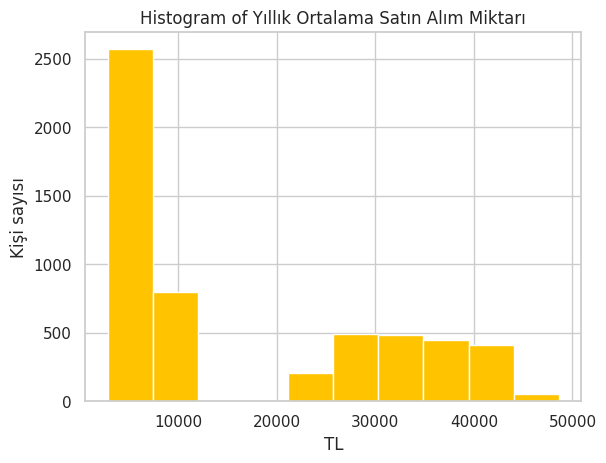

In [ ]:
plt.hist(training_df["Yıllık Ortalama Satın Alım Miktarı"])
plt.title("Histogram of Yıllık Ortalama Satın Alım Miktarı")
plt.xlabel("TL")
plt.ylabel("Kişi sayısı")
plt.show()

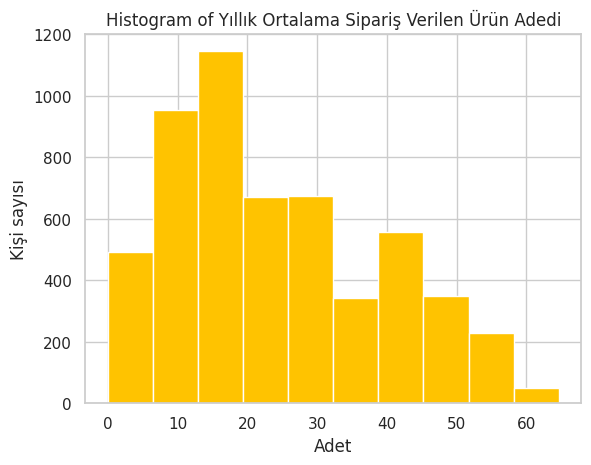

In [ ]:
plt.hist(training_df["Yıllık Ortalama Sipariş Verilen Ürün Adedi"])
plt.title("Histogram of Yıllık Ortalama Sipariş Verilen Ürün Adedi")
plt.xlabel("Adet")
plt.ylabel("Kişi sayısı")
plt.show()

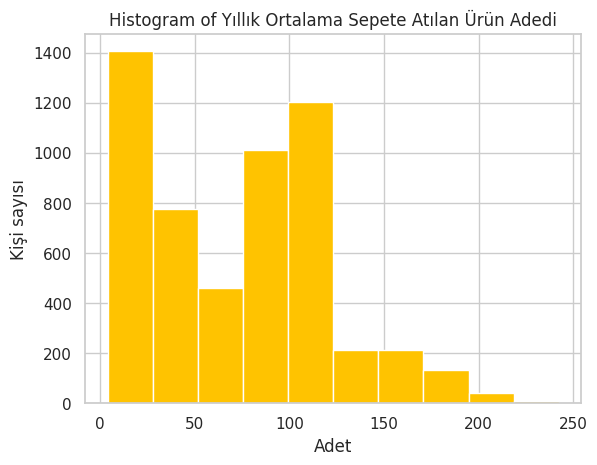

In [ ]:
plt.hist(training_df["Yıllık Ortalama Sepete Atılan Ürün Adedi"])
plt.title("Histogram of Yıllık Ortalama Sepete Atılan Ürün Adedi")
plt.xlabel("Adet")
plt.ylabel("Kişi sayısı")
plt.show()

In [ ]:
def satinalim_grubu(val):
    """
    We grouped people based on how much they spend annually on purchasing products.
    We found the threshold values by examining the average values.
    """

    if val < 5000:
        return "çok düşük"
    elif val >= 5000 and val < 10000:
        return "az düşük"
    elif val >= 10000 and val < 25000:
        return "orta"
    elif val >= 25000 and val < 40000:
        return "yüksek"
    else:
        return "çok yüksek"

def alisveriskolik_grubu(val):
    """
    To group based on the values in the "Annual Average Number of Products Ordered" column,
    we wrote this function. We also selected these values by examining the histogram.
    """

    if val < 10:
        return "çok az"
    elif val >= 10 and val < 20:
        return "az"
    elif val >= 20 and val < 30:
        return "normal"
    elif val >= 30 and val < 40:
        return "çok"
    elif val >= 40 and val < 50:
        return "çok çok"
    else:
        return "abartma"

def acgozlu_grubu(val):
    """
    To group based on the values in the "Annual Average Number of Products Added to Cart" column,
    we determined the threshold values from the histogram.
    We called those who added items to their cart greedy, but actually it would be more accurate to say enthusiastic.
    After all, how many of us keep items in the cart and don't remove them after seeing the total cost?
    """

    if val < 50:
        return "az"
    elif val >= 50 and val < 100:
        return "normal"
    elif val >= 100 and val < 150:
        return "çok"
    else:
        return "acgozlu"

def add_more_features(df):

    # Create a new feature called "NEW_Satin_Alim_Grubu" by applying the "satinalim_grubu" function
    # to the "Yıllık Ortalama Satın Alım Miktarı" column based on how much they spend annually on purchasing products.
    df["NEW_Satin_Alim_Grubu"] = df["Yıllık Ortalama Satın Alım Miktarı"].apply(satinalim_grubu).tolist()

    # Create a new feature called "NEW_Alisveris_Grubu" by applying the "alisveriskolik_grubu" function
    # to the "Yıllık Ortalama Sipariş Verilen Ürün Adedi" column based on the number of products ordered annually.
    df["NEW_Alisveris_Grubu"] = df["Yıllık Ortalama Sipariş Verilen Ürün Adedi"].apply(alisveriskolik_grubu).tolist()

    # Create a new feature called "NEW_Acgozlu_Grubu" by applying the "acgozlu_grubu" function
    # to the "Yıllık Ortalama Sepete Atılan Ürün Adedi" column based on the number of products added to the cart annually.
    df["NEW_Acgozlu_Grubu"] = df["Yıllık Ortalama Sepete Atılan Ürün Adedi"].apply(acgozlu_grubu).tolist()

    age_dict = {"18-30": 24.0, "31-40": 35.0, "41-50": 45.0, "51-60": 55.0, ">60": 65.0}
    df["NEW_Age"] = [age_dict[str_] for str_ in df["Yaş Grubu"].tolist()]

    return df


In [ ]:
def prepare_files_more_feats(DIR_, list_cat_cols, list_numerical_cols):
    """
    A copy of prepare_files_w_extra_2_feats(DIR_, list_cat_cols, list_numerical_cols)
    We are just trying to add more new features for our validation experiments.

    Inputs:
        DIR_               : Directory where the files are located.
        list_cat_cols      : List of categorical column names.
        list_numerical_cols: List of numerical column names.
    """

    # Reading the data from scratch
    train = pd.read_csv(DIR_ + "train.csv")
    test = pd.read_csv(DIR_ + "test_x.csv")

    train = prepare_df(train)
    test = prepare_df(test) # Remove the index from this

    # Transformation of the target (TARGET) variable (from String to label numbers)
    y_labels_str = train[TARGET]
    conv_str2num_dict, conv_num2str_dict = class_str2num(y_labels_str)
    y_labels_num = [conv_str2num_dict[str_] for str_ in y_labels_str]

    y_labels_num = np.array(y_labels_num)  # 0,1...7
    train.drop(TARGET, axis=1, inplace=True)

    # Add two new features to both sets
    train = add_more_features(train)
    test = add_more_features(test)

    list_cat_cols.extend(["NEW_Satin_Alim_Grubu", "NEW_Alisveris_Grubu", "NEW_Acgozlu_Grubu"])
    list_numerical_cols.extend(["NEW_Age"])

    # One Hot Encoding
    train = pd.get_dummies(train, columns=list_cat_cols, drop_first=True)
    test = pd.get_dummies(test, columns=list_cat_cols, drop_first=True)

    # Standardization for numerical variables
    scaler = StandardScaler()
    train[list_numerical_cols] = scaler.fit_transform(train[list_numerical_cols])
    test[list_numerical_cols] = scaler.transform(test[list_numerical_cols])

    # Total number of clusters
    num_classes = len(set(y_labels_str))

    return train, y_labels_num, y_labels_str, test, num_classes, list_cat_cols, list_numerical_cols


In [ ]:
# Data Preprocessing and Pre-Model Processing
training_df = pd.read_csv(DIR_ + "train.csv")
training_df = prepare_df(training_df)

analyzer = DataframeAnalyzer(training_df)

categorical_cols = analyzer.get_categorical_cols()
numerical_cols = analyzer.get_numerical_cols()

train, y_labels_num, y_labels_str, test, num_classes, list_cat_cols, list_numerical_cols = prepare_files_more_feats(DIR_, categorical_cols, numerical_cols)
train.head(3)

Number of categorical_cols: 8
Number of numerical_cols: 4


,Yıllık Ortalama Gelir,Yıllık Ortalama Satın Alım Miktarı,Yıllık Ortalama Sipariş Verilen Ürün Adedi,Yıllık Ortalama Sepete Atılan Ürün Adedi,NEW_Age,Cinsiyet_Kadın,Yaş Grubu_31-40,Yaş Grubu_41-50,Yaş Grubu_51-60,Yaş Grubu_>60,Medeni Durum_Evli,Eğitim Düzeyi_Doktora Ötesi,Eğitim Düzeyi_Eğitimsiz,Eğitim Düzeyi_Lise Mezunu,Eğitim Düzeyi_Ortaokul Mezunu,Eğitim Düzeyi_Yüksek Lisans Mezunu,Eğitim Düzeyi_Yüksekokul Mezunu,Eğitim Düzeyi_Üniversite Mezunu,Eğitim Düzeyi_İlkokul Mezunu,İstihdam Durumu_Emekli,İstihdam Durumu_Kendi İşinin Sahibi,İstihdam Durumu_İşsiz veya Düzenli Bir İşi Yok,Yaşadığı Şehir_Köy veya Kasaba,Yaşadığı Şehir_Küçük Şehir,Yaşadığı Şehir_Kırsal,En Çok İlgilendiği Ürün Grubu_Ev ve Mobilya,En Çok İlgilendiği Ürün Grubu_Giyim,En Çok İlgilendiği Ürün Grubu_Kozmetik,En Çok İlgilendiği Ürün Grubu_Spor Malzemeleri,Eğitime Devam Etme Durumu_Etmiyor,NEW_Satin_Alim_Grubu_orta,NEW_Satin_Alim_Grubu_yüksek,NEW_Satin_Alim_Grubu_çok düşük,NEW_Satin_Alim_Grubu_çok yüksek,NEW_Alisveris_Grubu_az,NEW_Alisveris_Grubu_normal,NEW_Alisveris_Grubu_çok,NEW_Alisveris_Grubu_çok az,NEW_Alisveris_Grubu_çok çok,NEW_Acgozlu_Grubu_az,NEW_Acgozlu_Grubu_normal,NEW_Acgozlu_Grubu_çok
0,1.751048,1.091958,0.887949,0.624683,-0.274344,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1
1,-0.533799,-0.884593,-0.835505,0.184927,1.880005,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,1,0
2,-0.432366,-0.474698,2.095272,1.444947,-1.064272,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
knn_params = {"n_neighbors": [8]}

rf_params = {"max_depth": [8],
             "max_features": [8],
             "min_samples_split": [15],
             "n_estimators": [300]}


lightgbm_params = {"learning_rate": [0.01],
                   "n_estimators": [300],
                   "colsample_bytree": [0.7, 1],
                   'objective': ['multiclass'],
                    'metric': ['multi_logloss'],  # For multiclass classification, 'multi_error' is used with 1 - accuracy
                    'num_class': [num_classes],           # Number of classes in the dataset
                    'boosting_type': ['gbdt'],
                    'num_leaves': [31],
                    'feature_fraction': [0.9],
                    'bagging_fraction': [0.8],
                    'bagging_freq': [5],
                    'verbose': [0]}

classifiers = [('KNN', KNeighborsClassifier(), knn_params),
               #("CART", DecisionTreeClassifier(), cart_params),
               ("RF", RandomForestClassifier(), rf_params),
               #('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgboost_params),
               ('LightGBM', LGBMClassifier(), lightgbm_params)]

def base_models(X, y, scoring="accuracy"):
    print("Base Models....")
    
    # A list containing the names of classification models to be evaluated.
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))
                   ]

    for name, classifier in classifiers:
        # Evaluating classifiers with cross-validation.
        cv_results = cross_validate(classifier, X, y, cv=5, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

base_models(train, y_labels_num)



Base Models....
accuracy: 0.9513 (LR) 
accuracy: 0.9482 (KNN) 
accuracy: 0.9526 (SVC) 
accuracy: 0.8991 (CART) 
accuracy: 0.9542 (RF) 
accuracy: 0.8987 (Adaboost) 
accuracy: 0.948 (GBM) 
accuracy: 0.9529 (XGBoost) 
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1100
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 42
[LightGBM] [Info] Start training from score -2.064896
[LightGBM] [Info] Start training from score -2.299842
[LightGBM] [Info] Start training from score -2.061292
[LightGBM] [Info] Start training from score -2.025953
[LightGBM] [Info] Start training from score -2.047006
[LightGBM] [Info] Start training from score -2.072142
[LightGBM] [Info] Start tr

In [ ]:
best_models = hyperparameter_optimization(train, y_labels_num)

voting_clf_new_feature = voting_classifier(best_models, train, y_labels_num)
joblib.dump(voting_clf_new_feature, "voting_clf_new_feature.pkl")


Hyperparameter Optimization....
########## KNN ##########
accuracy (Before): 0.9482
accuracy (After): 0.9498
KNN best params: {'n_neighbors': 8}

########## RF ##########
accuracy (Before): 0.954
accuracy (After): 0.9544
RF best params: {'max_depth': 8, 'max_features': 8, 'min_samples_split': 15, 'n_estimators': 300}

########## LightGBM ##########
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1100
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 42
[LightGBM] [Info] Start training from score -2.064896
[LightGBM] [Info] Start training from score -2.299842
[LightGBM] [Info] Start training from score -2.061292
[LightGBM] [Info] Start training from score -2.02595

['voting_clf_new_feature.pkl']

"Mean accuracy" is almost the same as the previous ensemble model, with a change starting from the fourth decimal place. Let's see how it affects the test set on how many samples it becomes evident:

In [ ]:
predicted=voting_clf_new_feature.predict(test)

sample_submission = pd.read_csv(DIR_+"sample_submission.csv")
sample_submission = sample_submission.iloc[:1].reindex(range(len(predicted)))
sample_submission["id"] = range(len(predicted))
sample_submission[TARGET] = convert_test2str(predicted, conv_num2str_dict)

sample_submission.to_csv('new_feature_lgbm-knn-rf.csv', index = False) 
sample_submission


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


,id,Öbek İsmi
0,0,obek_3
1,1,obek_3
2,2,obek_2
3,3,obek_6
4,4,obek_1
...,...,...
2335,2335,obek_8
2336,2336,obek_2
2337,2337,obek_7
2338,2338,obek_5


## 3.3) Third Model

In [ ]:
def add_much_more_features(df):
    df["NEW_Ortalama_TekUrun_Fiyati"] = df["Yıllık Ortalama Satın Alım Miktarı"] / (df["Yıllık Ortalama Sipariş Verilen Ürün Adedi"]  + 0.0001)
    df["NEW_Greed"] = df["Yıllık Ortalama Sepete Atılan Ürün Adedi"] / (df["Yıllık Ortalama Sipariş Verilen Ürün Adedi"] + 0.0001)
    df["NEW_Greed2"] = df["Yıllık Ortalama Sepete Atılan Ürün Adedi"] - df["Yıllık Ortalama Sipariş Verilen Ürün Adedi"]
    df["NEW_Savings"] = df['Yıllık Ortalama Gelir'] - df['Yıllık Ortalama Satın Alım Miktarı']
    df["NEW_Aylik_Gelir"] = df['Yıllık Ortalama Gelir']/12.0
    df["NEW_Aylik_Satin_Alim"] = df["Yıllık Ortalama Satın Alım Miktarı"] / 12.0

    df["NEW_Gelir_Grubu"] = df["Yıllık Ortalama Gelir"].apply(get_income_group)
    df = gender_age_merge(df)
    df["NEW_Satin_Alim_Grubu"] = df["Yıllık Ortalama Satın Alım Miktarı"].apply(satinalim_grubu).tolist()
    df["NEW_Alisveris_Grubu"] = df["Yıllık Ortalama Sipariş Verilen Ürün Adedi"].apply(alisveriskolik_grubu).tolist()
    df["NEW_Acgozlu_Grubu"] = df["Yıllık Ortalama Sepete Atılan Ürün Adedi"].apply(acgozlu_grubu).tolist()
    # Calculate "NEW_Aylik_Satin_Alim" as the monthly average purchase amount by dividing the "Yıllık Ortalama Satın Alım Miktarı" value.

    age_dict = {"18-30": 24.0, "31-40": 35.0, "41-50": 45.0, "51-60": 55.0, ">60": 65.0}

    df["NEW_Age"] = [age_dict[str_] for str_ in df["Yaş Grubu"].tolist()]

    return df

def prepare_files_more_x_feats(DIR_, list_cat_cols, list_numerical_cols):
    """
    This function can be considered as a copy of prepare_files_w_extra_2_feats(DIR_, list_cat_cols, list_numerical_cols).

    We are only trying to add more new features to our validation experiments.

    Inputs:
        DIR_               : The directory where the files are located.
        list_cat_cols      : List of categorical column names.
        list_numerical_cols: List of numerical column names.
    """

    # Reading the data from scratch
    train = pd.read_csv(DIR_ + "train.csv")
    test = pd.read_csv(DIR_ + "test_x.csv")

    train = prepare_df(train)
    test = prepare_df(test) # Remove the index from this as well

    # Transforming the target variable (from string labels to label numbers)
    y_labels_str = train[TARGET]
    conv_str2num_dict, conv_num2str_dict = class_str2num(y_labels_str)
    y_labels_num = [conv_str2num_dict[str_] for str_ in y_labels_str]
    
    y_labels_num = np.array(y_labels_num)  # 0,1...7
    train.drop(TARGET, axis=1, inplace=True)

    # Adding two new features to both sets
    train = add_much_more_features(add_2_new_features(train))
    test = add_much_more_features(add_2_new_features(test))
    
    list_cat_cols.extend(["NEW_Satin_Alim_Grubu", "NEW_Alisveris_Grubu", "NEW_Acgozlu_Grubu", 
                            "NEW_Gelir_Grubu", "gender_age","NEW_Income_Group"])
    list_numerical_cols.extend(["NEW_Ortalama_TekUrun_Fiyati", "NEW_Greed", "NEW_Greed2", "NEW_Savings",
                                "NEW_Aylik_Gelir", "NEW_Aylik_Satin_Alim", "NEW_Age"])

    # One Hot Encoding
    train = pd.get_dummies(train, columns=list_cat_cols, drop_first=True)
    test = pd.get_dummies(test, columns=list_cat_cols, drop_first=True)
 
    # Standardization for numerical variables
    scaler = StandardScaler()
    train[list_numerical_cols] = scaler.fit_transform(train[list_numerical_cols])
    test[list_numerical_cols] = scaler.transform(test[list_numerical_cols])

    # Total number of clusters
    num_classes = len(set(y_labels_str))

    return train, y_labels_num, y_labels_str, test, num_classes, list_cat_cols, list_numerical_cols




In [ ]:
training_df = pd.read_csv(DIR_ + "train.csv")
training_df = prepare_df(training_df)

analyzer = DataframeAnalyzer(training_df)

categorical_cols = analyzer.get_categorical_cols()
numerical_cols = analyzer.get_numerical_cols()

categorical_cols = analyzer.get_categorical_cols()
numerical_cols = analyzer.get_numerical_cols()

train, y_labels_num, y_labels_str, test, num_classes, list_cat_cols, list_numerical_cols = prepare_files_more_x_feats(DIR_, categorical_cols, numerical_cols)
train.head(3)

Number of categorical_cols: 8
Number of numerical_cols: 4


,Yıllık Ortalama Gelir,Yıllık Ortalama Satın Alım Miktarı,Yıllık Ortalama Sipariş Verilen Ürün Adedi,Yıllık Ortalama Sepete Atılan Ürün Adedi,NEW_Ortalama_TekUrun_Fiyati,NEW_Greed,NEW_Greed2,NEW_Savings,NEW_Aylik_Gelir,NEW_Aylik_Satin_Alim,NEW_Age,Cinsiyet_Kadın,Yaş Grubu_31-40,Yaş Grubu_41-50,Yaş Grubu_51-60,Yaş Grubu_>60,Medeni Durum_Evli,Eğitim Düzeyi_Doktora Ötesi,Eğitim Düzeyi_Eğitimsiz,Eğitim Düzeyi_Lise Mezunu,Eğitim Düzeyi_Ortaokul Mezunu,Eğitim Düzeyi_Yüksek Lisans Mezunu,Eğitim Düzeyi_Yüksekokul Mezunu,Eğitim Düzeyi_Üniversite Mezunu,Eğitim Düzeyi_İlkokul Mezunu,İstihdam Durumu_Emekli,İstihdam Durumu_Kendi İşinin Sahibi,İstihdam Durumu_İşsiz veya Düzenli Bir İşi Yok,Yaşadığı Şehir_Köy veya Kasaba,Yaşadığı Şehir_Küçük Şehir,Yaşadığı Şehir_Kırsal,En Çok İlgilendiği Ürün Grubu_Ev ve Mobilya,En Çok İlgilendiği Ürün Grubu_Giyim,En Çok İlgilendiği Ürün Grubu_Kozmetik,En Çok İlgilendiği Ürün Grubu_Spor Malzemeleri,Eğitime Devam Etme Durumu_Etmiyor,NEW_Satin_Alim_Grubu_orta,NEW_Satin_Alim_Grubu_yüksek,NEW_Satin_Alim_Grubu_çok düşük,NEW_Satin_Alim_Grubu_çok yüksek,NEW_Alisveris_Grubu_az,NEW_Alisveris_Grubu_normal,NEW_Alisveris_Grubu_çok,NEW_Alisveris_Grubu_çok az,NEW_Alisveris_Grubu_çok çok,NEW_Acgozlu_Grubu_az,NEW_Acgozlu_Grubu_normal,NEW_Acgozlu_Grubu_çok,NEW_Gelir_Grubu_Orta Gelir,NEW_Gelir_Grubu_Yüksek Gelir,gender_age_genc_kadin,gender_age_orta_erkek,gender_age_orta_kadin,gender_age_yasli_erkek,gender_age_yasli_kadin,NEW_Income_Group_Orta Gelir,NEW_Income_Group_Yüksek Gelir
0,1.751048,1.091958,0.887949,0.624683,-0.084428,-0.083886,0.415854,1.763000,1.751048,1.091958,-0.274344,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1
1,-0.533799,-0.884593,-0.835505,0.184927,-0.084539,-0.083363,0.543905,-0.500311,-0.533799,-0.884593,1.880005,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0
2,-0.432366,-0.474698,2.095272,1.444947,-0.084580,-0.083910,0.946058,-0.421516,-0.432366,-0.474698,-1.064272,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0


In [ ]:
knn_params = {"n_neighbors": [8]}

rf_params = {"max_depth": [8],
             "max_features": [8],
             "min_samples_split": [15],
             "n_estimators": [300]}


lightgbm_params = {"learning_rate": [0.01],
                   "n_estimators": [300],
                   "colsample_bytree": [0.7, 1],
                   'objective': ['multiclass'],
                    'metric': ['multi_logloss'],  # For multiclass classification, 'multi_error' is used with 1 - accuracy
                    'num_class': [num_classes],           # Number of classes in the dataset
                    'boosting_type': ['gbdt'],
                    'num_leaves': [31],
                    'feature_fraction': [0.9],
                    'bagging_fraction': [0.8],
                    'bagging_freq': [5],
                    'verbose': [0]}

classifiers = [('KNN', KNeighborsClassifier(), knn_params),
               #("CART", DecisionTreeClassifier(), cart_params),
               ("RF", RandomForestClassifier(), rf_params),
               #('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgboost_params),
               ('LightGBM', LGBMClassifier(), lightgbm_params)]

def base_models(X, y, scoring="accuracy"):
    print("Base Models....")
    
    # A list containing the names of classification models to be evaluated.
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ('LightGBM', LGBMClassifier())
                   # ('CatBoost', CatBoostClassifier(verbose=False))
                   ]

    for name, classifier in classifiers:
        # Evaluating classifiers with cross-validation.
        cv_results = cross_validate(classifier, X, y, cv=5, scoring=scoring,error_score='raise')
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

base_models(train, y_labels_num)



Base Models....
accuracy: 0.9502 (LR) 
accuracy: 0.9505 (KNN) 
accuracy: 0.9524 (SVC) 
accuracy: 0.9011 (CART) 
accuracy: 0.9546 (RF) 
accuracy: 0.891 (Adaboost) 
accuracy: 0.9462 (GBM) 
accuracy: 0.9529 (XGBoost) 
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2648
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 57
[LightGBM] [Info] Start training from score -2.064896
[LightGBM] [Info] Start training from score -2.299842
[LightGBM] [Info] Start training from score -2.061292
[LightGBM] [Info] Start training from score -2.025953
[LightGBM] [Info] Start training from score -2.047006
[LightGBM] [Info] Start training from score -2.072142
[LightGBM] [Info] Start tr

In [ ]:
best_models = hyperparameter_optimization(train, y_labels_num)

voting_clf_new_feature = voting_classifier(best_models, train, y_labels_num)
joblib.dump(voting_clf_new_feature, "voting3_clf_new_feature.pkl")


Hyperparameter Optimization....
########## KNN ##########
accuracy (Before): 0.9505
accuracy (After): 0.9507
KNN best params: {'n_neighbors': 8}

########## RF ##########
accuracy (Before): 0.9544
accuracy (After): 0.9546
RF best params: {'max_depth': 8, 'max_features': 8, 'min_samples_split': 15, 'n_estimators': 300}

########## LightGBM ##########
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2648
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 57
[LightGBM] [Info] Start training from score -2.064896
[LightGBM] [Info] Start training from score -2.299842
[LightGBM] [Info] Start training from score -2.061292
[LightGBM] [Info] Start training from score -2.0259

['voting3_clf_new_feature.pkl']

In [ ]:
predicted=voting_clf_new_feature.predict(test)

sample_submission = pd.read_csv(DIR_+"sample_submission.csv")
sample_submission = sample_submission.iloc[:1].reindex(range(len(predicted)))
sample_submission["id"] = range(len(predicted))
sample_submission[TARGET] = convert_test2str(predicted, conv_num2str_dict)

sample_submission.to_csv('new_extra_feature_lgbm-knn-rf.csv', index = False) 
sample_submission


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


,id,Öbek İsmi
0,0,obek_3
1,1,obek_3
2,2,obek_2
3,3,obek_6
4,4,obek_1
...,...,...
2335,2335,obek_8
2336,2336,obek_2
2337,2337,obek_7
2338,2338,obek_5


## 4) Bagging Ensemble & Human-in-the-loop

This ensemble is entirely unsupervised. Let's compare the results of the two test sets and see how much difference there is between them:

In [5]:
def get_different_samples(df1, df2):
    different_filter = df1 != df2
    a = pd.DataFrame()
    
    for column in df1.columns:
        different_values_in_column = different_filter[column]
        a[f"1.DF - {column}"] = df1[column][different_values_in_column]
        a[f"2.DF - {column}"] = df2[column][different_values_in_column]
    
    a.drop(columns=["1.DF - id","2.DF - id"],inplace=True)
    return a 

model1 = pd.read_csv("lgbm-knn-rf.csv")
model2 = pd.read_csv('new_feature_lgbm-knn-rf.csv')

diff_df = get_different_samples(model1, model2)

diff_df

,1.DF - Öbek İsmi,2.DF - Öbek İsmi
158,obek_1,obek_3
866,obek_1,obek_3
977,obek_2,obek_5
1332,obek_1,obek_3


In [6]:
model1 = pd.read_csv("lgbm-knn-rf.csv")
model3 = pd.read_csv('new_extra_feature_lgbm-knn-rf.csv')

diff_df = get_different_samples(model1, model3)

diff_df

,1.DF - Öbek İsmi,2.DF - Öbek İsmi
158,obek_1,obek_3
866,obek_1,obek_3
977,obek_2,obek_5
1332,obek_1,obek_3


In [7]:
def get_different_samples(df1, df2):
    different_filter = df1 != df2
    a = pd.DataFrame()
    
    for column in df1.columns:
        different_values_in_column = different_filter[column]
        a[f"1.DF - {column}"] = df1[column][different_values_in_column]
        a[f"2.DF - {column}"] = df2[column][different_values_in_column]
        
    return a 

model2 = pd.read_csv("new_feature_lgbm-knn-rf.csv")
model3 = pd.read_csv('new_extra_feature_lgbm-knn-rf.csv')

diff_df = get_different_samples(model2, model3)

diff_df

,1.DF - id,2.DF - id,1.DF - Öbek İsmi,2.DF - Öbek İsmi


When the cross-validation results of the two classifiers are almost identical, there are differences in the classification of 5 samples in the test results. According to majority voting, sample number 1787 is actually classified as "obek_2" by 2 out of 3 models. Therefore, we will eliminate it as "obek_2".

The fact that the classification results of "new_feature_lgbm-knn-rf" and "new_extra_feature_lgbm-knn-rf" methods are 100% identical doesn't convince us due to the high similarity of features.

Interestingly, while the first model calls what the second model refers to as "obek_1" as "obek_3", it calls what the second model refers to as "obek_2" as "obek_5". "obek_1" and "obek_3", as well as "obek_2" and "obek_5", are mixed up. Here are the descriptions of the clusters we had made earlier:

- Obek 1 (mostly engaged in clothing and cosmetics shopping, low educational level, under 60 years old): This group adds the fewest products to the cart and makes the fewest purchases.

- Obek 3 (includes married men of all ages, they buy everything except cosmetics, most of them are high school graduates, they mostly do not live in rural areas): They add few products to the cart.

- Obek 2 (mostly consists of married women, they shop for clothing and furniture, the highest educational level is usually high school, mostly unemployed, under 60 years old): They have both low income and low spending.

- Obek 5 (mostly males aged 18-40, high school graduates, not living in rural areas, none of them are retired): They add a lot to the cart but don't make purchases, and they have low income.

Let's see the contents in the test set:

In [10]:
test_raw = pd.read_csv(DIR_ + "test_x.csv")

# Let's make the final submission a copy of model1, which provided the highest 5-fold cross-validation result in the validation set.
final_submission = model1.copy()

In [11]:
test_raw.iloc[158] #seems to be a sample where the model had some difficulty determining whether it belongs 
#to cluster 1 or cluster 3. Considering the categorical information, it might not make sense for this individual to belong to both groups.
# To make a decision, you analyzed the numerical columns, particularly focusing on the "Yıllık Ortalama Sipariş Verilen Ürün Adedi" 
#feature.
#In this case, the "Yıllık Ortalama Sipariş Verilen Ürün Adedi" value is around 15,
#which aligns more with cluster 3 where the average is about 15.
#On the other hand, cluster 1 has an average value of around 10-12 and does not go higher. 
#Considering this numerical feature, it would be reasonable to classify this sample as belonging to cluster 3.

#So, based on the analysis, you decided to rely on the result of Model1 for this specific sample.

index                                                                    158
Cinsiyet                                                               Erkek
Yaş Grubu                                                              51-60
Medeni Durum                                                            Evli
Eğitim Düzeyi                                                 Doktora Mezunu
İstihdam Durumu                               Düzenli ve Ücretli Bir İşi Var
Yıllık Ortalama Gelir                                          203304.492896
Yaşadığı Şehir                                                   Küçük Şehir
En Çok İlgilendiği Ürün Grubu                                          Giyim
Yıllık Ortalama Satın Alım Miktarı                                5798.36523
Yıllık Ortalama Sipariş Verilen Ürün Adedi                         12.058319
Eğitime Devam Etme Durumu                                            Etmiyor
Yıllık Ortalama Sepete Atılan Ürün Adedi                           14.281226

In [20]:
print(test_raw.iloc[866]) # Mixed between cluster 1 and 3.
# Cluster 1 was a younger group, while in cluster 3, the distribution of different age groups seems to be higher compared to cluster 1.
# The number of items added to the cart is completely equal to the number of items ordered, indicating that the person buys what they put in the cart.
# At the same time, the order counts are low. It's challenging to classify this person. Additional analysis is needed.

train_raw = pd.read_csv(DIR_ + "train.csv")
print(train_raw[(train_raw["Yaş Grubu"] == ">60") & 
     (train_raw["Cinsiyet"] == "Erkek") & 
     (train_raw[TARGET] == "obek_1") & 
     (~train_raw["Eğitim Düzeyi"].isin(["Yüksek Lisans Mezunu", "Üniversite Mezunu", "Doktora Ötesi", 
                                        "Doktora Mezunu", "Yüksekokul Mezunu"]))])

print("\n")
print(train_raw[(train_raw["Yaş Grubu"] == ">60") & 
     (train_raw["Cinsiyet"] == "Erkek") & 
     (train_raw[TARGET] == "obek_3") & 
     (~train_raw["Eğitim Düzeyi"].isin(["Yüksek Lisans Mezunu", "Üniversite Mezunu", "Doktora Ötesi", 
                                        "Doktora Mezunu", "Yüksekokul Mezunu"]))])

# Based on the analysis, in terms of age, gender, and education level criteria, there were 90 people in cluster 3 and 15 people in cluster 1.
# We can only label this person with the result of Model 2 or Model 3.
final_submission[TARGET][866] = model2[TARGET][866]

index                                                                    866
Cinsiyet                                                               Erkek
Yaş Grubu                                                                >60
Medeni Durum                                                           Bekar
Eğitim Düzeyi                                                 İlkokul Mezunu
İstihdam Durumu                               İşsiz veya Düzenli Bir İşi Yok
Yıllık Ortalama Gelir                                          358624.163245
Yaşadığı Şehir                                                   Büyük Şehir
En Çok İlgilendiği Ürün Grubu                                          Giyim
Yıllık Ortalama Satın Alım Miktarı                               5709.280131
Yıllık Ortalama Sipariş Verilen Ürün Adedi                         11.578165
Eğitime Devam Etme Durumu                                            Etmiyor
Yıllık Ortalama Sepete Atılan Ürün Adedi                           11.578165

In [21]:
test_raw.iloc[977]
# Mixed between cluster_2 and cluster_5.
# (cluster_2 mainly consisted of unemployed women who shopped for clothing, similar to housewives.
# cluster_5, on the other hand, was predominantly male.
# This person should belong to cluster_2. I have more confidence in the Model1 result here.)


index                                                                    977
Cinsiyet                                                               Kadın
Yaş Grubu                                                              18-30
Medeni Durum                                                           Bekar
Eğitim Düzeyi                                                    Lise Mezunu
İstihdam Durumu                               İşsiz veya Düzenli Bir İşi Yok
Yıllık Ortalama Gelir                                          165832.516134
Yaşadığı Şehir                                               Köy veya Kasaba
En Çok İlgilendiği Ürün Grubu                                          Giyim
Yıllık Ortalama Satın Alım Miktarı                               4144.014521
Yıllık Ortalama Sipariş Verilen Ürün Adedi                          8.708317
Eğitime Devam Etme Durumu                                            Etmiyor
Yıllık Ortalama Sepete Atılan Ürün Adedi                           69.294935

In [22]:
test_raw.iloc[1332]
# Mixed between cluster_1 and cluster_3.
# (cluster_1 was buying cosmetics, while cluster_3 was not. This should belong to cluster_1. I trust Model1's result in this example.)


index                                                                   1332
Cinsiyet                                                               Erkek
Yaş Grubu                                                              18-30
Medeni Durum                                                            Evli
Eğitim Düzeyi                                                 İlkokul Mezunu
İstihdam Durumu                               Düzenli ve Ücretli Bir İşi Var
Yıllık Ortalama Gelir                                          232040.391483
Yaşadığı Şehir                                                   Büyük Şehir
En Çok İlgilendiği Ürün Grubu                                       Kozmetik
Yıllık Ortalama Satın Alım Miktarı                               5764.448897
Yıllık Ortalama Sipariş Verilen Ürün Adedi                         11.749308
Eğitime Devam Etme Durumu                                            Etmiyor
Yıllık Ortalama Sepete Atılan Ürün Adedi                           13.651035

In the human-intervention process, we have only changed the result of a single data point with the result of Model2 or Model3 based on the Model1 results. Now, we can save this file and prepare it for submission:

In [23]:
final_submission.to_csv("Ensamble-rf-knn-lgbm.csv", index=False)

# With this result, Score in the public test set: 0.96195
# Private score on private test set: 0.95200

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=88d435bb-04e3-4b54-a36b-59ced22d48e2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>